<a href="https://colab.research.google.com/github/vale-p-i/SalaryPrediction/blob/master/SalaryPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import random
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, precision_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_validate, StratifiedShuffleSplit
import statistics

# Analisi dei dati

Come primo step, carichiamo il dataframe e studiamo la sua natura.

In [277]:
df = pd.read_csv('/content/salary.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  salary          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Il dataset presenta ben 32561 entry. Ogni riga del dataset corrisponde a una persona e contiene informazioni riguardanti la sua istruzione, il suo lavoro e altri dettagli personali, tra cui l'età, il sesso, lo stato civile e l'etnia. Per quanto riguarda il tipo dei dati, il dataset presenta 6 variabili numeriche e 9 variabili categoriche. Inoltre, sono presenti due variabili ***education*** ed ***education-num*** che potrebbero essere in qualche modo correlate tra di loro. Da questa prima analisi, utilizzando il metodo ***info()***, sembra che non ci siano valori nulli. Tuttavia, è necessario controllare le variabili categoriche per verificare che non ci siano valori che indicano la mancanza dei dati.

Analizziamo in maniera generale la distribuzione delle variabili numeriche.

In [278]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


Facciamo lo stesso per quelle categoriche.

In [279]:
df.describe(include='object')

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,salary
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


## Gestione dei valori nulli

Esaminiamo quali sono i vari valori che assume ciascuna variabile categorica.

In [280]:
cat_features = [i for i in df if df[i].dtype == 'object']
for feature in cat_features:
  print(feature)
  print()
  print(df[feature].unique())
  print()

workclass

[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']

education

[' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']

marital-status

[' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']

occupation

[' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' ' ?'
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv']

relationship

[' Not-in-family' ' Husband' ' Wife' ' Own-child' ' Unmarried'
 ' Other-relative']

race

[' White' ' Black' ' Asian-Pac-Islander' ' Amer-Indian-Eskimo' ' Other']

sex

[' Male' ' Female']

native-country

[' United-States' ' Cuba' ' Jama

Tre variabili, ***workclass*** , ***occupation*** e ***native-country*** presentano nel loro range di valori la stringa ' ?', la quale indica che per quell'istanza quel dato non è noto: non conoscere il dato equivale a non averlo dato. Una possibile soluzione per poter gestire questo problema è eliminare le righe corrispondenti. Altrimenti, si potrebbero utilizzare tecniche di imputazione dei dati, cercando di ricavare in qualche modo il valore del dato mancante. Non trattandosi di variabili numeriche, non è possibile effettuare una stima. Si potrebbe provare a vedere, invece, se tramite qualche correlazione è possibile ricavare il valore della variabile. Nel caso di ***native-country***, non c'è nessun'altra variabile da cui si può dedurre il paese di origine della persona: i dati mancanti di questa variabile vanno eliminati. Per quanto riguarda ***workclass*** e ***occupation***, queste due variabili possono essere considerate in un qualche modo correlate tra di loro, perché la prima indica la classe di lavoro della persona, mentre la seconda indica il suo impiego. Esaminiamo se una categoria della variabile ***occupation*** possa essere associata a una particolare categoria della variabile ***workclass***, esaminando le categorie che la variabile ***occupation*** assume quando l'altra ha valore ' ?'.

In [281]:
df1 = df[df['workclass'] == ' ?']
df1['occupation'].value_counts()

 ?    1836
Name: occupation, dtype: int64

In [282]:
df2 = df[df['occupation'] == ' ?']
df2['workclass'].value_counts()

 ?               1836
 Never-worked       7
Name: workclass, dtype: int64

Notiamo che per le 1836 istanze in cui ***occupation*** assume valore ' ?', anche ***workclass*** assume valore ' ?'. Nelle restanti 7 istanze in cui ***occupation*** è ' ?', ***workclass*** assume valore 'Never-worked'. Essendo impossibile dedurre questi valori, è ragionevole eliminare anche le istanze che presentano valori mancanti di ***occupation*** e ***workclass***. Per semplificare e velocizzare questo processo, possiamo trasformare ogni occorrenza della stringa ' ?' in *Nan* e successivamente eliminare le istanze che presentano almeno un valore Nan, utilizzando il metodo ***dropna***.

In [283]:
df = df.replace(' ?', np.NaN)
df.isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
salary               0
dtype: int64

Gestiamo i valori nulli eliminando le righe corrispondenti.

In [284]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30162 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30162 non-null  int64 
 1   workclass       30162 non-null  object
 2   fnlwgt          30162 non-null  int64 
 3   education       30162 non-null  object
 4   education-num   30162 non-null  int64 
 5   marital-status  30162 non-null  object
 6   occupation      30162 non-null  object
 7   relationship    30162 non-null  object
 8   race            30162 non-null  object
 9   sex             30162 non-null  object
 10  capital-gain    30162 non-null  int64 
 11  capital-loss    30162 non-null  int64 
 12  hours-per-week  30162 non-null  int64 
 13  native-country  30162 non-null  object
 14  salary          30162 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Eliminati i valori nulli, il numero di entry è sceso a 30162. Sono state eliminate 2399 istanze, ossia circa il 7% del dataset. Ora andiamo ad analizzare ciascuna variabile nel dettaglio.

## Variabile target

### Salary

Per analizzare alcune variabili del dataset, potrebbe essere opportuno esaminare la correlazione tra la variabile (o le variabili) in questione e la variabile target, che in questo caso è la variabile ***salary***. Di conseguenza, è necessario trasformare la variabile ***salary*** in formato numerico. Per fare ciò, visto che le classi in totale sono solo due, '<=50k' e '>50k', possiamo  mappare la prima classe a 0 e la seconda a 1. Questa operazione è nota come encoding binario e, in questo caso, può essere eseguito con il metodo *map* di pandas o con il LabelEncoder della libreria scikit-learn.

In [285]:
label_encoder = LabelEncoder()
df['salary'] = label_encoder.fit_transform(df['salary'])

<ipython-input-285-9cbf7077e028>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['salary'] = label_encoder.fit_transform(df['salary'])


In teoria, il LabelEncoder non è il codificatore opportuno per effettare la codifica binaria: il suo scopo, infatti, è codificare le variabili categoriche in numeri interi. In questo caso specifico, però, siccome ci sono solo due classi e vogliamo solo una colonna che rappresenta il salario, è possibile usare il LabelEncoder al posto del One Hot Encoder, il quale, invece, effettua la codifica binaria. È bene sottolineare che, poiché la maggior parte degli algoritmi di machine learning lavorano unicamente con variabili numeriche, sarà necessario codificare ogni variabile categorica utilizzata per addestrare e testare il modello, in variabile categorica numerica. Solitamente ciò viene fatto dopo la fase di analisi del dataset. Come detto, è stato deciso di codificare la variabile target in questa fase così da poter studiare più accuratamente i dati.

Avendo codificato la variabile target, analizziamo il bilanciamento del dataset, controllando quante istanze appartengano alla classe 0, ossia la classe delle persone che hanno un salario inferiore o uguale a 50k, e quante alla classe 1, ossia quella delle persone che guadagnano più di 50k.

In [286]:
num_entries = len(df)
zero_count = len(df[(df['salary'] == 0)])
one_count = len(df[(df['salary'] == 1)])
print(f"Totale 0: {zero_count}")
print("Percentuale 0: {:.2f}%".format((100*zero_count)/num_entries))
print(f"Totale 1: {one_count}")
print("Percentuale 1: {:.2f}%".format((100*one_count)/num_entries))

Totale 0: 22654
Percentuale 0: 75.11%
Totale 1: 7508
Percentuale 1: 24.89%


Il dataset non è molto bilanciato: le 22654 entry della classe 0 sono nettamente superiori alle 7508 entry della classe 1. Potremmo considerare di bilanciare il dataset, magari utilizzando delle tecniche di oversampling o undersampling.

Il prossimo passo è analizzare le altre variabili del dataset. Suddividiamo l'analisi, considerando prima le variabili numeriche, poi quelle categoriche. Tutte le modifiche importanti, come l'eliminazione di dati, il raggruppamento delle categorie, la categorizzazione e la normalizzazione, verranno effettuate in un secondo momento, dopo aver effettuato l'analisi dei dati.

## Variabili numeriche

Vediamo come sono distribuite nel dataset le variabili numeriche e quali sono i loro range di valori.

In [287]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,salary
count,30162.000000,3.016200e+04,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000
mean,38.437902,1.897938e+05,10.121312,1092.007858,88.372489,40.931238,0.248922
std,13.134665,1.056530e+05,2.549995,7406.346497,404.298370,11.979984,0.432396
min,17.000000,1.376900e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.176272e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.784250e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,47.000000,2.376285e+05,13.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


È possibile immediatamente notare che le due variabili ***capital-gain*** e ***capital-loss*** non sono molto bilanciate: per almeno il 75% del dataset, le due variabili hanno valore 0. Inoltre, insieme alla variabile ***fnlwgt***, queste tre variabili presentano un range di valori molto ampio: è necessario in questi casi normalizzare/scalare la variabile. Per quanto riguarda le variabili ***age*** e ***hours-per-week***, la prima ha un range di valori che va da 17 a 90, la seconda da 1 a 99. Per queste variabili si può o applicare la normalizzazione, per scalare il range di valori, oppure la categorizzazzione, definendo delle categorie a partire dai dati. Si è deciso di usare entrambi gli approcci, per poi confrontarne i risultati.  La variabile ***education-num*** ha un range di valori che va da 0 a 16 e sembra essere correlata alla variabile categorica ***education***: per questo motivo verranno analizzate insieme successivamente.

In [288]:
df.skew(numeric_only=True)

age                0.530228
fnlwgt             1.459220
education-num     -0.305379
capital-gain      11.902682
capital-loss       4.526380
hours-per-week     0.330869
salary             1.161408
dtype: float64

Con il metodo ***skew*** di pandas è possibile stabilire quanto sia simmetrica la distribuzione di una variabile numerica. Teoricamente, se il valore di "skewness" è compreso tra 0,5 e -0,5, allora possiamo ritenere che la variabile sia simmetrica. Se è compreso tra 0,5 e 1 oppure -0,5 e -1, allora la variabile è leggermente asimmetrica. Invece, se la skewness è maggiore di 1 o minore di -1, allora la variabile è altamente asimmetrica. In questo caso possiamo stabilire che le variabili ***hours-per-week***, ***education-num*** e ***age***  sono simmetriche. Invece, le variabili ***fnlwgt***, ***capital-loss*** e ***capital-gain*** sono altamente asimmetriche.

Nelle prossime sezioni, andremo ad analizzare la distribuzione delle variabili numeriche ed eventualmente la loro correlazione con la variabile target, ossia ***salary***.

### Age

La variabile ***age*** indica l'età di una persona. Analizziamo graficamente, tramite l'utilizzo di un grafico a barre, la sua distribuzione in correlazione con ***salary***.

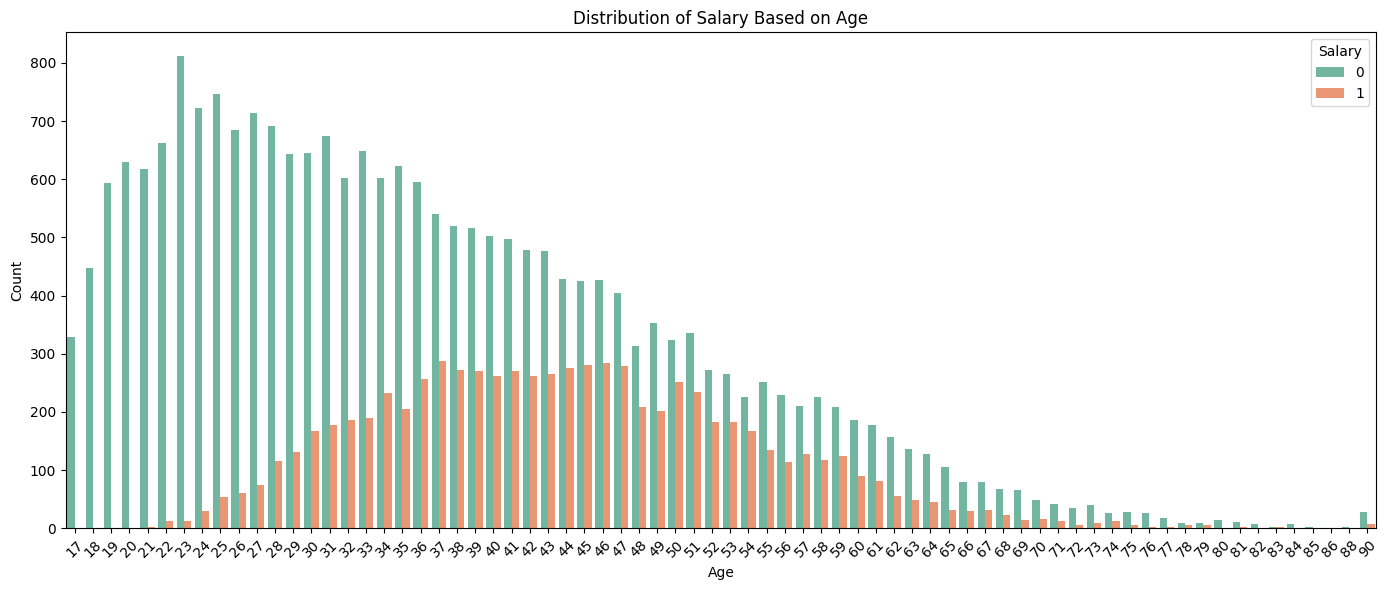

In [289]:
plt.figure(figsize=(14, 6))
sns.countplot(x='age', hue='salary', data=df, palette='Set2')
plt.title('Distribution of Salary Based on Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Salary')
plt.tight_layout()
plt.show()
plt.close()

La maggior parte delle persone nel dataset hanno un'età compresa i 20 e i 50 anni. Utilizzando la variabile ***salary***, è possibile notare che le persone con un'età compresa tra i 17 e i 27 anni guadagnano di meno rispetto alle persone con un'età compresa tra i 28 e i 50 anni. Al di sopra dei 50 anni, le persone che guadagno meno di 50k tendono ad essere il doppio di quelle che guadagnano più di 50k.

### Hours per week

La variabile ***hours per week*** indica le ore di lavoro settimanali di una persona. Analizziamo la distribuzione di questa variabile.

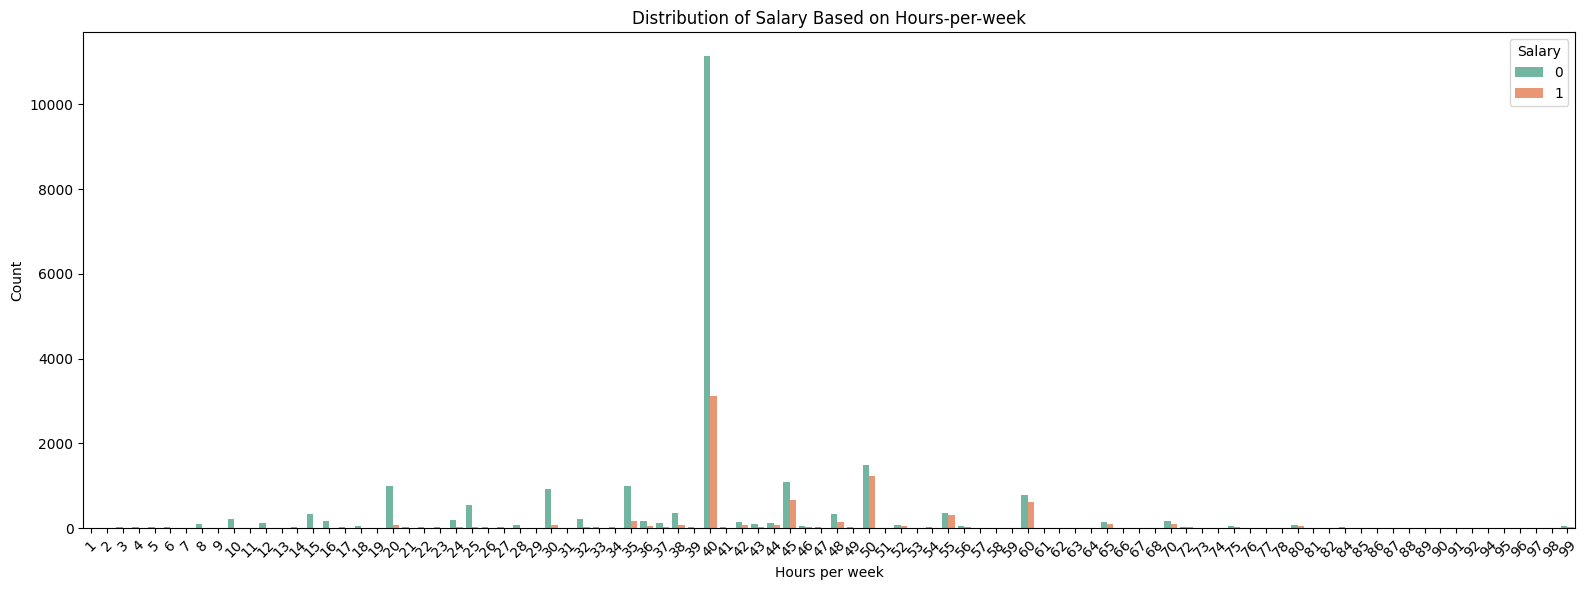

In [290]:
plt.figure(figsize=(16, 6))
sns.countplot(x='hours-per-week', hue='salary', data=df, palette='Set2')
plt.title('Distribution of Salary Based on Hours-per-week')
plt.xlabel('Hours per week')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Salary')
plt.tight_layout()
plt.show()
plt.close()

La prima cosa che si nota è che c'è un valore predominante, ossia 40. Nonostante la variabile sia simmetrica, i valori non sono distribuiti in maniera continua. Di conseguenza, in questo caso, avrebbe più senso categorizzare la variabile, piuttosto che scalarla. Una possibile categorizzazione consisterebbe nel suddividere i dati in tre categorie: '40', '<40', '>40'.

### Capital gain and Capital loss

La variabile ***capital-gain*** rappresenta i profitti di una persona ottenuti tramite l'investimento. La variabile ***capital-loss*** rappresenta, invece, le perdite di una persona ottenute tramite l'investimento. Osserviamo la distribuzione di queste due variabili.

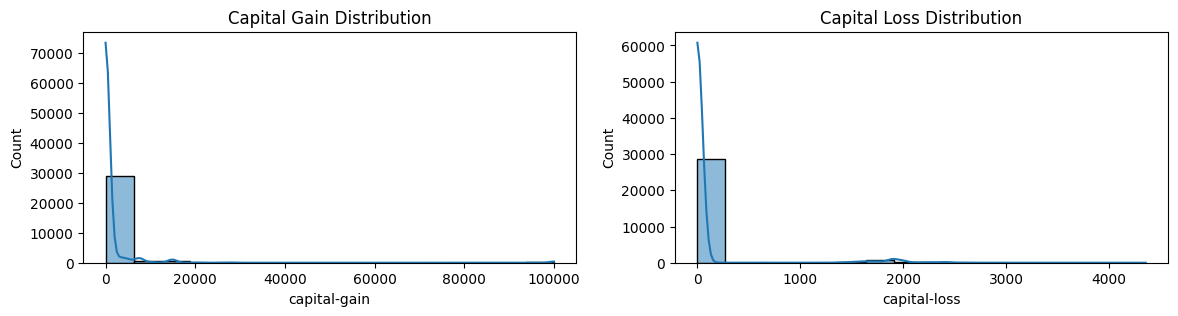

In [291]:
fig, ax = plt.subplots(1, 2, figsize=(14, 3))
sns.histplot(df['capital-gain'], ax=ax[0], kde=True)
ax[0].set_title('Capital Gain Distribution')
ax[0].xlabel = ('Capital Gain')
sns.histplot(df['capital-loss'], ax=ax[1], kde=True)
ax[1].set_title('Capital Loss Distribution')
ax[1].xlabel = ('Capital Loss')
plt.show()
plt.close()

Come avevamo previsto, entrambi le variabili non sono ben distribuite rispetto ai propri range di valori (0-99999 per capital-gain e 0-4356 per capital loss). Entrambe tendono verso sinistra, difatti la maggior parte delle istanze ha un ***capital-gain*** e/o un ***capital-loss*** pari a 0. Bisogna studiare la correlazione di queste due variabili: chi ha ottenuto dei guadagni può aver subito anche delle perdite? C'è chi non ha guadagnato nè perso niente? Cerchiamo si avere una risposta a queste domande.

In [292]:
df1 = df[(df['capital-gain'] > 0) & (df['capital-loss'] > 0)]
len(df1)

0

***capital-gain*** e ***capital-loss*** non possono essere entrambe maggiori di zero.

In [293]:
df2 = df[(df['capital-gain'] == 0) & (df['capital-loss'] == 0)]
len(df2)

26197

26197 istanze, dunque persone, non hanno investito, poiché non hanno avuto né dei guadagni né delle perdite.

In [294]:
df3 = df[(df['capital-gain'] > 0) & (df['capital-loss'] == 0)]
len(df3)

2538

2538 persone hanno guadagnato dai loro investimenti.

In [295]:
df4 = df[(df['capital-gain'] == 0) & (df['capital-loss'] > 0)]
len(df4)

1427

1427 persone hanno avuto delle perdite dai loro investimenti.

Considerato ciò, potremmo gestire queste due variabili andando a creare una variabile categorica che presenta tre categorie: una per chi non ha investito, una per chi ha avuto dei guadagni, una per chi ha subito delle perdite.

### Final Weight

La variabile ***fnlwgt***, che sta per "Final Weight", rappresenta un peso numerico calcolato, dai fornitori del dataset, su ogni persona sulla base di tre criteri. I fornitori del dataset affermano che: persone con caratteristiche demografiche simili dovrebbero avere pesi simili.

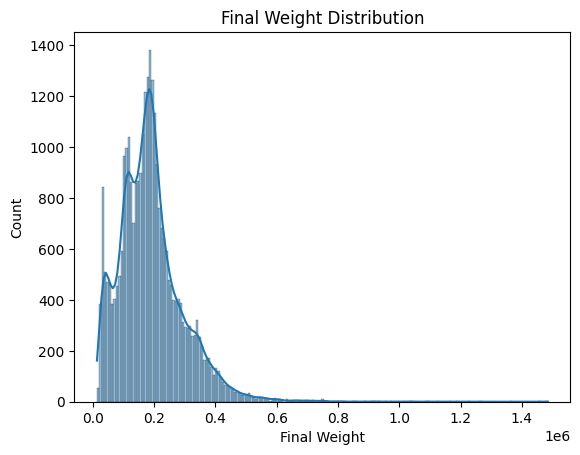

In [296]:
sns.histplot(df['fnlwgt'], kde=True, legend=False)
plt.xlabel('Final Weight')
plt.title('Final Weight Distribution')
plt.show()
plt.close()

La categoria ***fnlwgt*** ha un range che va da 13769 a 1484705.

Considerata la natura di questa variabile, ossia che sia un'informazione calcolata e fornita per questo dataset, non dispoibile nella realtà, potremmo definire la variabile un leaky predictor. In un eventuale utilizzo futuro del modello, rappresenterebbe un'informazione non nota. Di conseguenza, è stato deciso di non utilizzare questa variabile per la predizione.

## Variabili categoriche

Analizziamo in maniera generale la distribuzione delle variabili categoriche.

In [297]:
df.describe(include='object')

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
count,30162,30162,30162,30162,30162,30162,30162,30162
unique,7,16,7,14,6,5,2,41
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States
freq,22286,9840,14065,4038,12463,25933,20380,27504


È possibile notare che la variabile ***native-country*** presenta molte categorie e che allo stesso tempo una categoria, ossia 'United-States', ha un'elevata frequenza, ossia 27504 istanze: ciò significa che il 91% del dataset assume quel valore per. Questo potrebbe implicare che quest'informazione potrebbe non essere importante per la prediziane. Andremo ad analizzare la variabile nel dettaglio successivamente.

Ci sono altre tre variabili che presentano una categoria con un'elevata frequenza: ***workclass***, ***race*** e ***sex***. Tuttavia, hanno però un numero inferiore di categorie.

Ora andiamo ad analizzare nel dettaglio la distribuzione e le categorie di ogni variabile categorica.

### Education & Education-num

La variabile categorica ***education*** rappresenta il livello di istruzione di una persona. Come visto, presenta 16 categorie. Analizziamo la frequenza di ciascuna categoria.

In [298]:
df['education'].value_counts()

 HS-grad         9840
 Some-college    6678
 Bachelors       5044
 Masters         1627
 Assoc-voc       1307
 11th            1048
 Assoc-acdm      1008
 10th             820
 7th-8th          557
 Prof-school      542
 9th              455
 12th             377
 Doctorate        375
 5th-6th          288
 1st-4th          151
 Preschool         45
Name: education, dtype: int64

È possibile notare che ci sono alcune categorie che non rappresentano il conseguimento di un diploma, ma indicano a che anno arriva il livello di istruzione di una persona. Tutte le variabili che indicano dei gradi, rappresentano gli anni scolastici precedenti al diploma superiore. Potrebbe avere senso raggruppare queste categorie.

Come già detto, è presente un'altra variabile che fa riferimento all'istruzione, ossia ***education-num***, che però è una variabile di tipo numerico e che, come visto, presenta un range di valori che va da 1 a 16. Analizziamo la correlazione presente tra le due variabili. Innanzitutto, analizziamo le frequenze.

In [299]:
df['education-num'].value_counts()

9     9840
10    6678
13    5044
14    1627
11    1307
7     1048
12    1008
6      820
4      557
15     542
5      455
8      377
16     375
3      288
2      151
1       45
Name: education-num, dtype: int64

Osservando le frequenze, esse corripsondono alle frequenze delle categorie di ***education***. Ciò significa che ***education-num*** rappresenta una codifica ordinata della variabile categorica ***education***, ossia che ogni valore rappresenta una determinata categoria, e che le categorie sono state ordinate secondo il livello di istruzione. Di conseguenza, non abbiamo bisogno di entrambe le variabili ma solo di una delle due. Considerando i requisiti richiesti dagli algoritmi di machine learning, sarebbe logico mantenere la variabile già codificata.

Analizziamo ora che correlazione c'è tra il livello di istruzione e il salario, sia graficamente, tramite il grafico a barre, che numericamente, analizzando la media ottenuta sulla base del ***salary***. Utilizziamo la variabile ***education-num*** così da mantenere anche l'ordine in base al livello di istruzione.

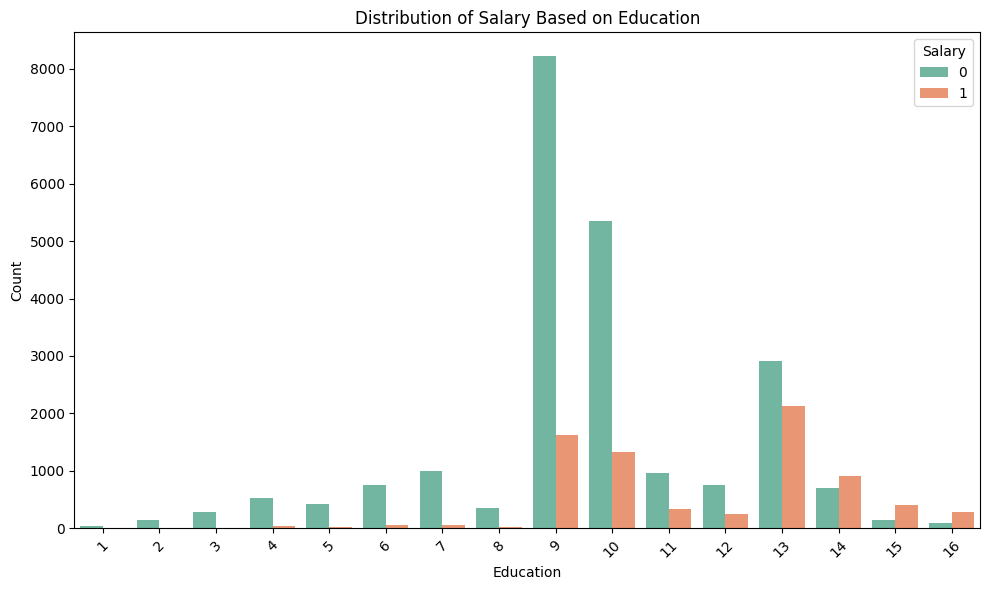

In [300]:
plt.figure(figsize=(10, 6))
sns.countplot(x='education-num', hue='salary', data=df, palette='Set2')
plt.title('Distribution of Salary Based on Education')
plt.xlabel('Education')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Salary')
plt.tight_layout()
plt.show()
plt.close()

Dal grafico si osserva che, innanzitutto, nel dataset, le persone che hanno un livello di istruzione inferiore al diploma di maturità sono poche e che tendono a guadagnare meno di 50k. Inoltre, si osserva che all'aumentare del livello di istruzione, nonostante la classe 0 sia predominante, si riduce il divario tra il numero di istanze appartenenti alla classe 0 e il numero di istanze appartenenti alla classe 1. Questo fenomeno persiste fino ai livelli di istruzione più elevanti, dove si osserva un'inversione di tale tendenza.


In [301]:
salary_mean = df.groupby(['education-num'])['salary'].mean()
salary_mean

education-num
1     0.000000
2     0.039735
3     0.041667
4     0.062837
5     0.054945
6     0.071951
7     0.056298
8     0.076923
9     0.164329
10    0.200060
11    0.263198
12    0.253968
13    0.421491
14    0.564229
15    0.749077
16    0.746667
Name: salary, dtype: float64

Le medie mostrano lo stesso trend: difatti, all'aumentare del livello di istruzione, la media si avvicina a 1. In altre parole, all'aumentare del livello di istruzione, le persone tendono a percepire uno stipendio più elevato.

Per quanto riguarda la gestione di questa variabile, si potrebbe di diminuire il numero di categorie, raggruppando le categorie simili tra loro.

### Marital status

La variabile categorica ***marital-status*** indica lo stato civile di una persona. Come abbiamo visto, presenta 7 categorie. Analizziamo la frequenza di ciascuna di queste categorie.

In [302]:
df['marital-status'].value_counts()

 Married-civ-spouse       14065
 Never-married             9726
 Divorced                  4214
 Separated                  939
 Widowed                    827
 Married-spouse-absent      370
 Married-AF-spouse           21
Name: marital-status, dtype: int64

Ci sono tre categorie che fanno riferimento a una persona sposata:
1. "Married-civ-spouse" significa che il coniuge della persone è un civile.
2. "Married-AF-spouse" significa che il coniuge della persona lavora nelle Forze Armate.
3. "Married-spouse-absent" significa che la persona è sposata, ma non vive con il coniuge.

'Married-Af-spouse' ha una frequenza molto bassa.
Osserviamo graficamente la correlazione tra lo stato civile e il salario.

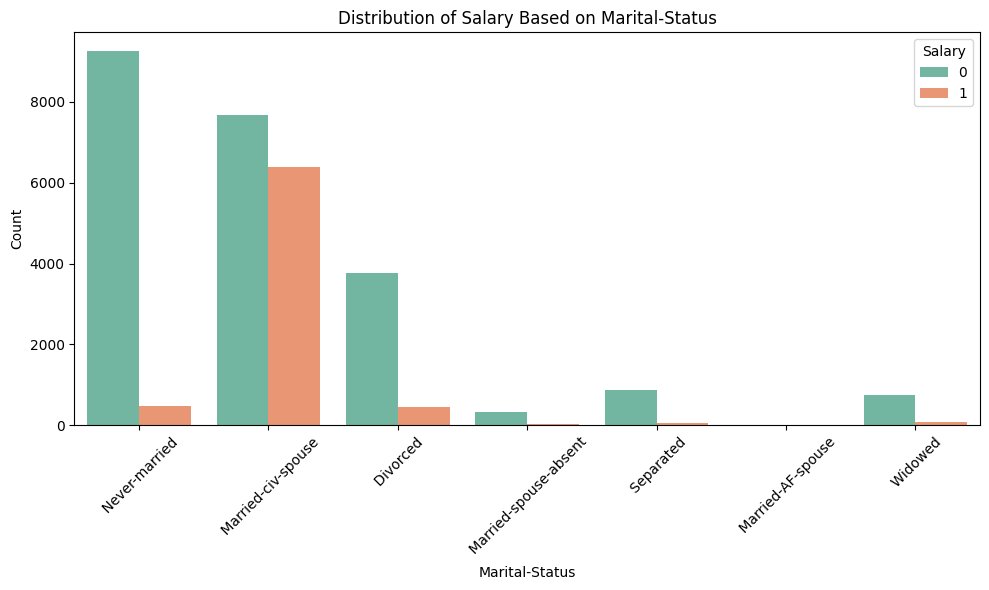

In [303]:
plt.figure(figsize=(10, 6))
sns.countplot(x='marital-status', hue='salary', data=df, palette='Set2')
plt.title('Distribution of Salary Based on Marital-Status')
plt.xlabel('Marital-Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Salary')
plt.tight_layout()
plt.show()
plt.close()

Una persona sposata tende a guadagnare di più rispetto a una persona non sposata, o rispetto a una persona che non sta più con il suo coniuge.

Concettualemente, ha senso raggruppare le categorie che indicano una persona sposata, così da diminuire il numero di categorie e accorpare 'Married-AF-spouse', che altrimenti avremmo dovuto eliminare.

In [304]:
salary_mean = df.groupby(['marital-status'])['salary'].mean()
salary_mean

marital-status
 Divorced                 0.107262
 Married-AF-spouse        0.476190
 Married-civ-spouse       0.454959
 Married-spouse-absent    0.083784
 Never-married            0.048324
 Separated                0.070288
 Widowed                  0.096735
Name: salary, dtype: float64

Esaminando le medie, si nota che 'Married-AF-spouse' e 'Married-civ-spouse' hanno anche una media abbastanza simile. La media di 'Married-spouse-absent', invece, si discosta molto dalle due, ma è molto vicina alla media di 'Separated', categoria che comunque indica concettualmente che la persona non vive con il coniuge.

### Relationship

La variabile categorica ***relationship*** dovrebbe indicare la relazione che la persona ha con le persone con cui vive. Come visto, ha 6 categorie. Analizziamo la loro frequenza.

In [305]:
df['relationship'].value_counts()

 Husband           12463
 Not-in-family      7726
 Own-child          4466
 Unmarried          3212
 Wife               1406
 Other-relative      889
Name: relationship, dtype: int64

La prima cosa da notare è che delle categorie richiamano alcune le categorie della variabile ***marital-status*** analizzata precedentemente. Ad esempio, 'Husband' e 'Wife', indicano che la persona è sposata, oppure c'è 'Unmarried' che indica che la persona non è sposata, come 'Never-Married' in ***marital-status***. Di conseguenza, possiamo affermare che c'è una sorta di ridondaza di dati.

Analizziamo graficamente la relazione con la variabile ***salary***.

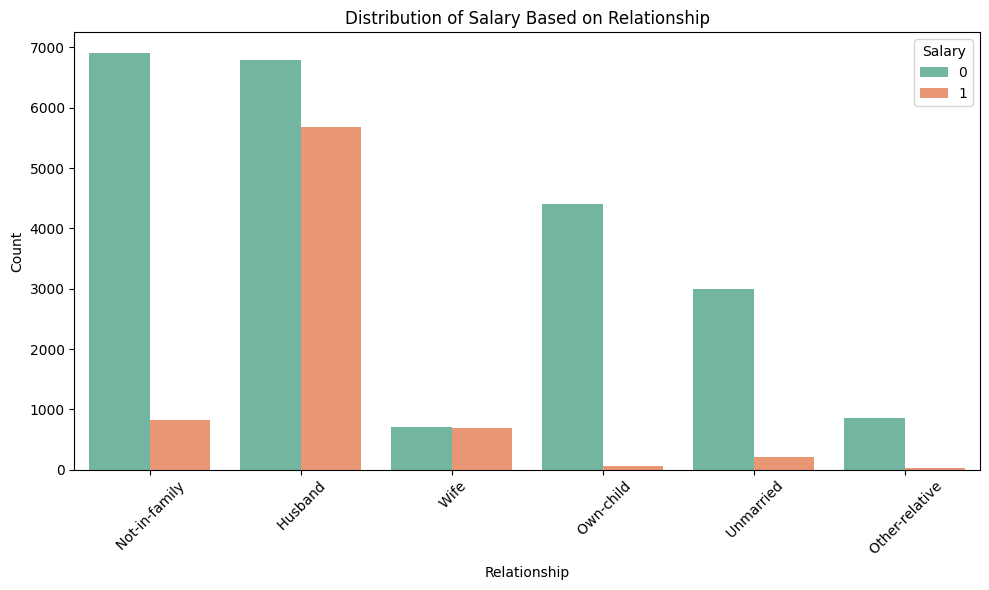

In [306]:
plt.figure(figsize=(10, 6))
sns.countplot(x='relationship', hue='salary', data=df, palette='Set2')
plt.title('Distribution of Salary Based on Relationship')
plt.xlabel('Relationship')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Salary')
plt.tight_layout()
plt.show()
plt.close()

Ancora una volta, risulta che le persone sposate tendono a guadagnare.

Come gestiamo la ridondaza dei dati? In teoria, se abbiamo una ridondanza, una delle due variabili va eliminata, perché non necessaria. Tuttavia, prima di decidere se eliminare la ridondanza, è opportuno studiare la correlazione tra le due variabili, così da poter capire come poter eventualemente migliorare il raggruppamento delle categorie.

Mostriamo, per ciascuna delle categorie di ***relationship***, quali valori assume la variabile ***marital-status***.

In [307]:
df1 = df[df['relationship'] == ' Own-child']
df1['marital-status'].value_counts()

 Never-married            3929
 Divorced                  308
 Separated                  90
 Married-civ-spouse         83
 Married-spouse-absent      43
 Widowed                    12
 Married-AF-spouse           1
Name: marital-status, dtype: int64

In [308]:
df2 = df[df['relationship'] == ' Other-relative']
df2['marital-status'].value_counts()

 Never-married            548
 Married-civ-spouse       118
 Divorced                 103
 Separated                 53
 Widowed                   40
 Married-spouse-absent     26
 Married-AF-spouse          1
Name: marital-status, dtype: int64

In [309]:
df2 = df[df['relationship'] == ' Unmarried']
df2['marital-status'].value_counts()

 Divorced                 1535
 Never-married             801
 Separated                 413
 Widowed                   343
 Married-spouse-absent     120
Name: marital-status, dtype: int64

In [310]:
df2 = df[df['relationship'] == ' Wife']
df2['marital-status'].value_counts()

 Married-civ-spouse    1396
 Married-AF-spouse       10
Name: marital-status, dtype: int64

In [311]:
df2 = df[df['relationship'] == ' Husband']
df2['marital-status'].value_counts()

 Married-civ-spouse    12454
 Married-AF-spouse         9
Name: marital-status, dtype: int64

In [312]:
df2 = df[df['relationship'] == ' Not-in-family']
df2['marital-status'].value_counts()

 Never-married            4448
 Divorced                 2268
 Widowed                   432
 Separated                 383
 Married-spouse-absent     181
 Married-civ-spouse         14
Name: marital-status, dtype: int64

Nelle istanze in cui ***relationship*** assume valore 'Husband' o 'Wife', la variabile ***marital-status*** assume come valore o 'Married-civ-spouse' o 'Married-AF-spouse': possiamo raggruppare queste due categorie in 'Married'. La categoria 'Married-spouse-absent' non compare. Siccome, invece, la maggior parte delle persone della categoria 'Married-spouse-absent' si sono definiti o 'Not-in-family' o 'Unmarried', non ha senso raggruppare anche questa categoria in 'Married'. Potrebbe avere più senso raggruppare insieme 'Separated' e 'Married-spouse-absent'.

### Workclass

La variabile ***workclass*** rappresenta la classe di lavoro di una persona. Ha 7 categorie, di cui di seguito analizziamo la frequenza.

In [313]:
df['workclass'].value_counts()

 Private             22286
 Self-emp-not-inc     2499
 Local-gov            2067
 State-gov            1279
 Self-emp-inc         1074
 Federal-gov           943
 Without-pay            14
Name: workclass, dtype: int64

Da un lato c'è la variabile 'Private' che, come visto, ha un'alta frequenza. Dall'altro, c'è la variabile 'Without-pay' che invece ha una frequenza molto bassa: solo 14 istanze, ossia meno dell'1% del dataset.
Analizziamo anche le medie sulla base del ***salary***.

In [314]:
salary_mean = df.groupby(['workclass'])['salary'].mean()
salary_mean

workclass
 Federal-gov         0.387063
 Local-gov           0.294630
 Private             0.218792
 Self-emp-inc        0.558659
 Self-emp-not-inc    0.285714
 State-gov           0.268960
 Without-pay         0.000000
Name: salary, dtype: float64

La media della categoria 'Without-pay', la quale indica le persone che non hanno uno stipendio, è (logicamente) di 0.00: le 14 istanze assumono tutte valore 0. La categoria rappresenta un'informazione non rilevante, sia perché per logica, una persona che si definisce la propria classe di lavoro 'Without-pay' deve giustamente appartenere alla classe '<=50k', sia perché rispetto alla grandezza del dataset, rappresenta una porzione microscopica. Per questo motivo, si potrebbe pensare di eliminare questa categoria, e ridurre il numero di categoria per la variabile ***workclass***.

Ora analizziamo la distribuzione della variabile ***workclass*** in relazione con la variabile ***salary***.

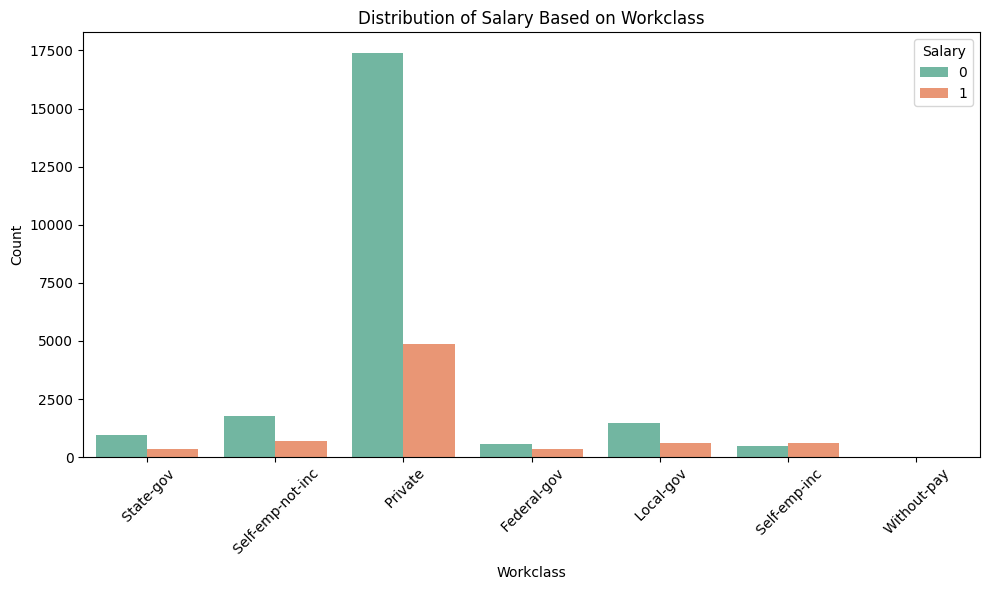

In [315]:
plt.figure(figsize=(10, 6))
sns.countplot(x='workclass', hue='salary', data=df, palette='Set2')
plt.title('Distribution of Salary Based on Workclass')
plt.xlabel('Workclass')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Salary')
plt.tight_layout()
plt.show()
plt.close()

Gran parte delle persone che lavorano nel privato, guadagnano meno di 50k. La classe di lavoro che tende a recepire uno stipendio elevato è 'Self-emp-inc'.

### Occupation

La variabile ***occupation*** rappresenta la professione della persona. Presenta 14 categorie, di cui di seguito mostriamo la frequenza.

In [316]:
df['occupation'].value_counts()

 Prof-specialty       4038
 Craft-repair         4030
 Exec-managerial      3992
 Adm-clerical         3721
 Sales                3584
 Other-service        3212
 Machine-op-inspct    1966
 Transport-moving     1572
 Handlers-cleaners    1350
 Farming-fishing       989
 Tech-support          912
 Protective-serv       644
 Priv-house-serv       143
 Armed-Forces            9
Name: occupation, dtype: int64

Non c'è una categoria predominante in questo caso, al contrario, c'è la categoria 'Armed-Forces' che ha solo 9 istanze: è una categoria che andrebbe eliminata.

Analizziamo la distribuzione della variabile ***occupation*** in relazione con ***salary***.

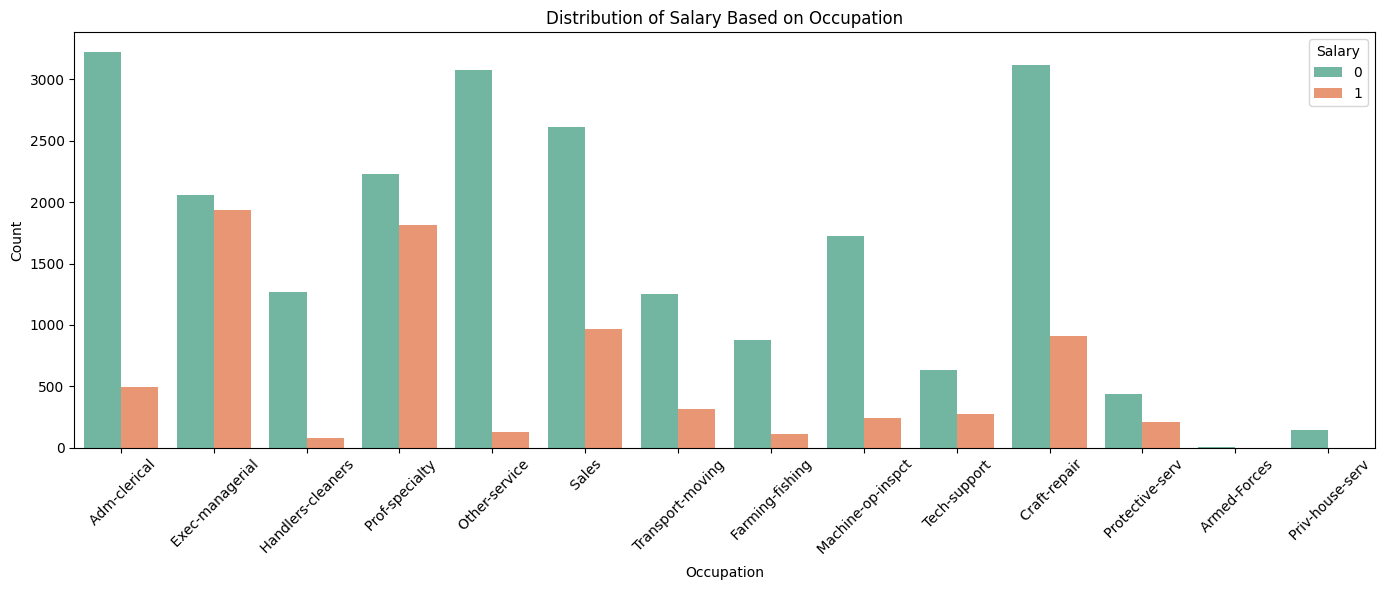

In [317]:
plt.figure(figsize=(14, 6))
sns.countplot(x='occupation', hue='salary', data=df, palette='Set2')
plt.title('Distribution of Salary Based on Occupation')
plt.xlabel('Occupation')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Salary')
plt.tight_layout()
plt.show()
plt.close()

Le persone che tendono a guadagnare di più sono 'Exec-managerial' e 'Prof-specialty'.

### Race

La variabile race indica l'etnia di una persona: presenta 5 categorie, di cui una è quella predominante ('White').

In [318]:
df['race'].value_counts()

 White                 25933
 Black                  2817
 Asian-Pac-Islander      895
 Amer-Indian-Eskimo      286
 Other                   231
Name: race, dtype: int64

Analizziamo la sua distribuzione sia graficamente che tramite l'utilizzo delle medie.

In [319]:
salary_mean = df.groupby(['race'])['salary'].mean()
salary_mean

race
 Amer-Indian-Eskimo    0.118881
 Asian-Pac-Islander    0.277095
 Black                 0.129925
 Other                 0.090909
 White                 0.263718
Name: salary, dtype: float64

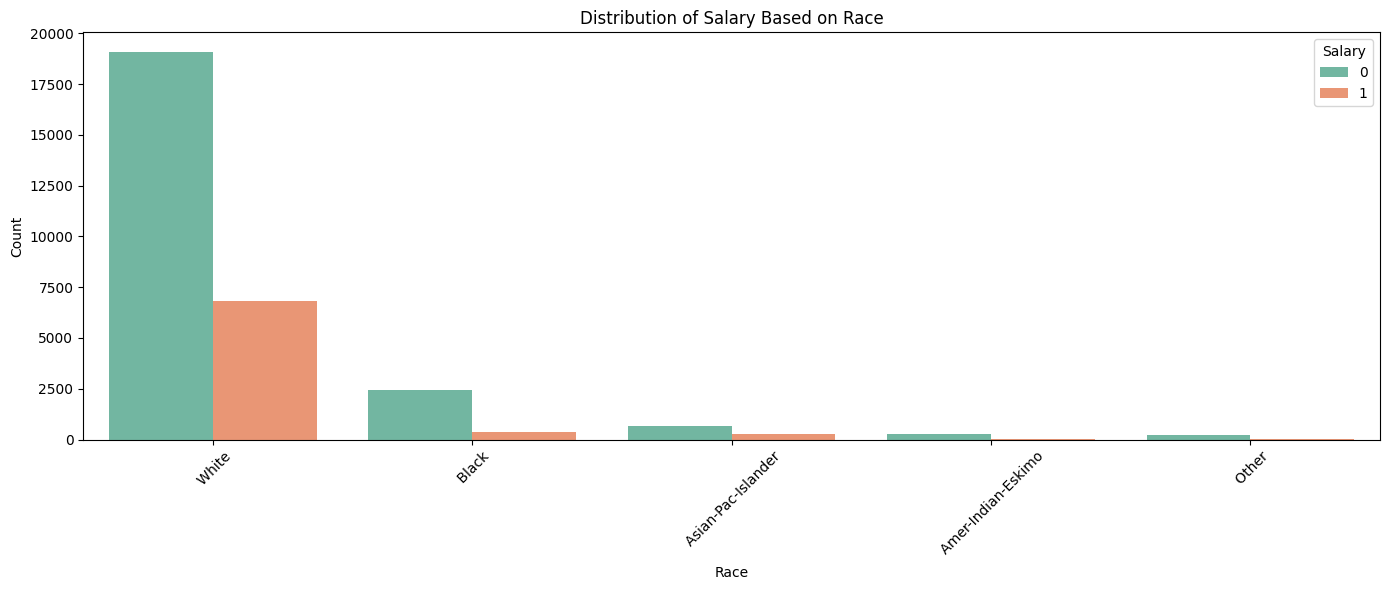

In [320]:
plt.figure(figsize=(14, 6))
sns.countplot(x='race', hue='salary', data=df, palette='Set2')
plt.title('Distribution of Salary Based on Race')
plt.xlabel('Race')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Salary')
plt.tight_layout()
plt.show()
plt.close()

Secondo questa suddivisione delle istanze del dataset, non c'è una variabile che presenta una media nettamente superiore rispetto alle altre. Questo perché la categoria 'White' contiene 25921 istanze, circa il 90% del dataset. Anche questa può essere considerata un'informazione non rilevante per il modello.

### Sex

La variabile ***sex*** indica il sesso della persona, presenta due categorie. Analizziamo la loro frequenza e distribuzione.

In [321]:
df['sex'].value_counts()

 Male      20380
 Female     9782
Name: sex, dtype: int64

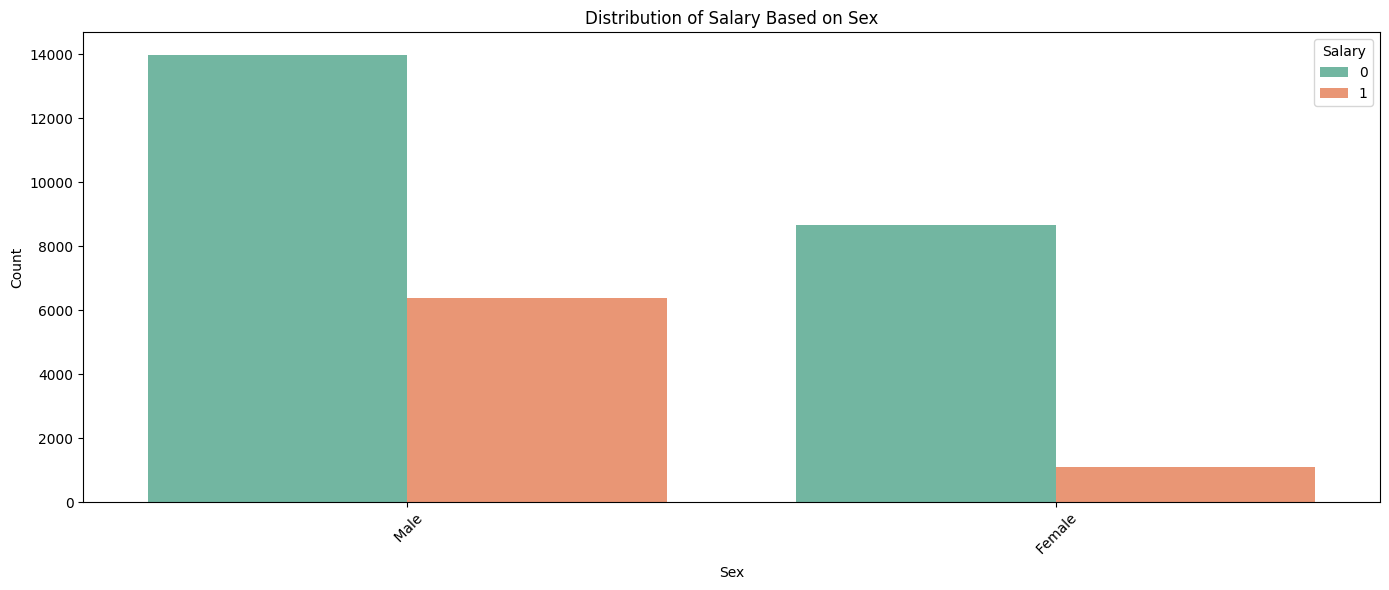

In [322]:
plt.figure(figsize=(14, 6))
sns.countplot(x='sex', hue='salary', data=df, palette='Set2')
plt.title('Distribution of Salary Based on Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Salary')
plt.tight_layout()
plt.show()
plt.close()

La categoria 'Male' è predominante. Inoltre, le persone appartenenti alla categoria 'Female' tendono a guadagnare di meno rispetto alle persone nella categoria 'Male'.

In [323]:
df1 = df[df['sex'] == ' Male']
df1['salary'].value_counts()

0    13984
1     6396
Name: salary, dtype: int64

In [324]:
df1 = df[df['sex'] == ' Female']
df1['salary'].value_counts()

0    8670
1    1112
Name: salary, dtype: int64

### Native Country

La variabile ***native-country*** indica lo stato di origine di una persona. Come avevamo visto, la categoria 'United-States' è quella predominante (rappresenta il 91% del dataset).

Analizziamo la frequenza e la correlazione delle altre categorie.

In [325]:
df['native-country'].value_counts()

 United-States                 27504
 Mexico                          610
 Philippines                     188
 Germany                         128
 Puerto-Rico                     109
 Canada                          107
 India                           100
 El-Salvador                     100
 Cuba                             92
 England                          86
 Jamaica                          80
 South                            71
 China                            68
 Italy                            68
 Dominican-Republic               67
 Vietnam                          64
 Guatemala                        63
 Japan                            59
 Poland                           56
 Columbia                         56
 Iran                             42
 Taiwan                           42
 Haiti                            42
 Portugal                         34
 Nicaragua                        33
 Peru                             30
 Greece                           29
 

Analizziamo anche le medie sulla base del salario.

In [326]:
salary_mean = df.groupby(['native-country'])['salary'].mean()
salary_mean

native-country
 Cambodia                      0.388889
 Canada                        0.336449
 China                         0.294118
 Columbia                      0.035714
 Cuba                          0.271739
 Dominican-Republic            0.029851
 Ecuador                       0.148148
 El-Salvador                   0.090000
 England                       0.348837
 France                        0.444444
 Germany                       0.343750
 Greece                        0.275862
 Guatemala                     0.047619
 Haiti                         0.095238
 Holand-Netherlands            0.000000
 Honduras                      0.083333
 Hong                          0.315789
 Hungary                       0.230769
 India                         0.400000
 Iran                          0.428571
 Ireland                       0.208333
 Italy                         0.352941
 Jamaica                       0.125000
 Japan                         0.389831
 Laos                    

Con questo gran numero di categorie e con la presenza di un valore dominante, la variabile non è usabile. Si era pensato di raggruppare le categorie, magari considerando i continenti dei singoli paesi. Tuttavia, è stato notato che, paesi appartenenti allo stesso continente come, 'France' e 'Scotland' (che appartengono al continente europero) hanno delle medie non correlate tra loro. Ciò è dovuto soprattutto dal fatto che, siccome per queste categorie il numero di istanze è poco più di alcune decine, si ha poca informazione e dunque non è possibile poter definire un trend dei dati. Di conseguenza, è stato decido di non considerare la variabile ***native-country*** per la predizione.

# Data preparation

## Feature Engineering

Per la normalizzazione è stato deciso di usare la normalizzazione MinMax, utilizzando il MinMaxScaler fornito dalla libreria *scikit-learn*.

In [327]:
minmax_scaler = MinMaxScaler()

### Age

Effettuiamo sia la categorizzazione che la normalizzazione della variabile ***age***. Per ognuna di queste operazioni, si andrà a creare una nuova variabile (colonna) nel dataset, così da poter analizzare in seguito quale operazione sia più efficiente. Per la normalizzazione creiamo la categoria ***age_scaled***, e per la categorizzazione creiamo la categoria ***age_cat***.

In [328]:
df['age_scaled'] = minmax_scaler.fit_transform(df[['age']])

Per la categorizzazione, si è deciso di usare quattro categorie, scelte in base alla distribuzione e l'andamento dei dati.

In [329]:
# bins = [17, 24, 30, 37, 70, float('inf')]
# labels = ['17-23', '24-29', '30-36', '37-69', '70+']
# df['age_cat_'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)
for i, row in df.iterrows():
  age = row['age']
  if age <= 23:
    df.loc[i, 'age_cat'] = 0
  elif 23 < age < 30:
    df.loc[i, 'age_cat'] = 1
  elif 30 <= age < 37:
    df.loc[i, 'age_cat'] = 2
  elif 37 <= age < 70:
    df.loc[i, 'age_cat'] = 3
  elif age >= 70:
    df.loc[i, 'age_cat'] = 4

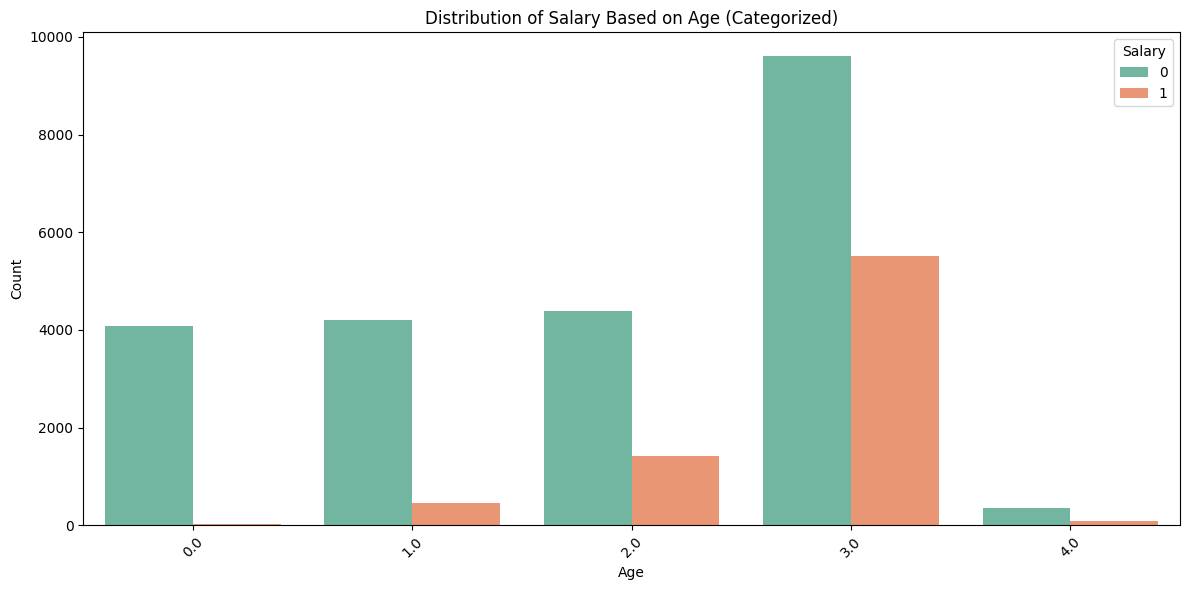

In [330]:
plt.figure(figsize=(12, 6))
sns.countplot(x='age_cat', hue='salary', data=df, palette='Set2')
plt.title('Distribution of Salary Based on Age (Categorized)')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Salary')
plt.tight_layout()
plt.show()
plt.close()

Analizziamo le medie della variabile ***age_cat*** appena creata, per valutare la qualità dei raggruppamenti.

In [332]:
salary_mean = df.groupby(['age_cat'])['salary'].mean()
salary_mean

age_cat
0.0    0.006801
1.0    0.099850
2.0    0.243369
3.0    0.364388
4.0    0.200893
Name: salary, dtype: float64

### Hours per week

Anche per questa variabili applichiamo sia la categorizzazione che la normalizzazione, creando due nuove variabili. Categorizziamo ***hours per week*** dividendo il dataset in tre categorie, fornendo già una codifica intera: 0 "<40", 1 per "40", 2 ">40".

In [333]:
for i, row in df.iterrows():
  hours = row['hours-per-week']
  if hours < 40:
    df.loc[i, 'hours-per-week_cat'] = 0
  elif hours == 40:
    df.loc[i, 'hours-per-week_cat'] = 1
  elif hours > 40:
    df.loc[i, 'hours-per-week_cat'] = 2

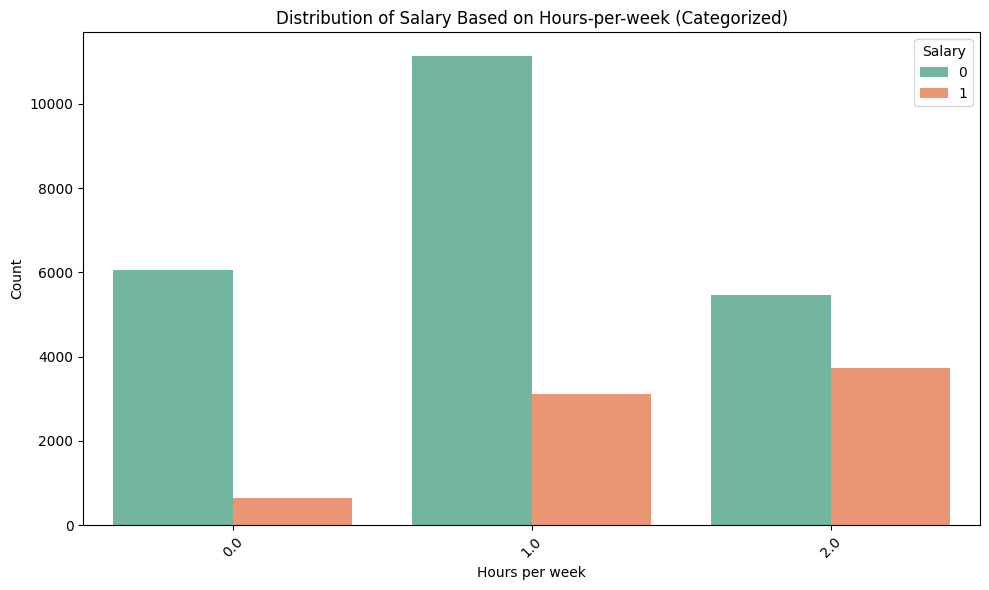

In [334]:
plt.figure(figsize=(10, 6))
sns.countplot(x='hours-per-week_cat', hue='salary', data=df, palette='Set2')
plt.title('Distribution of Salary Based on Hours-per-week (Categorized)')
plt.xlabel('Hours per week')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Salary')
plt.tight_layout()
plt.show()
plt.close()

Effettuiamo anche la normalizzazione.

In [335]:
df['hours-per-week_scaled'] = minmax_scaler.fit_transform(df[['hours-per-week']])

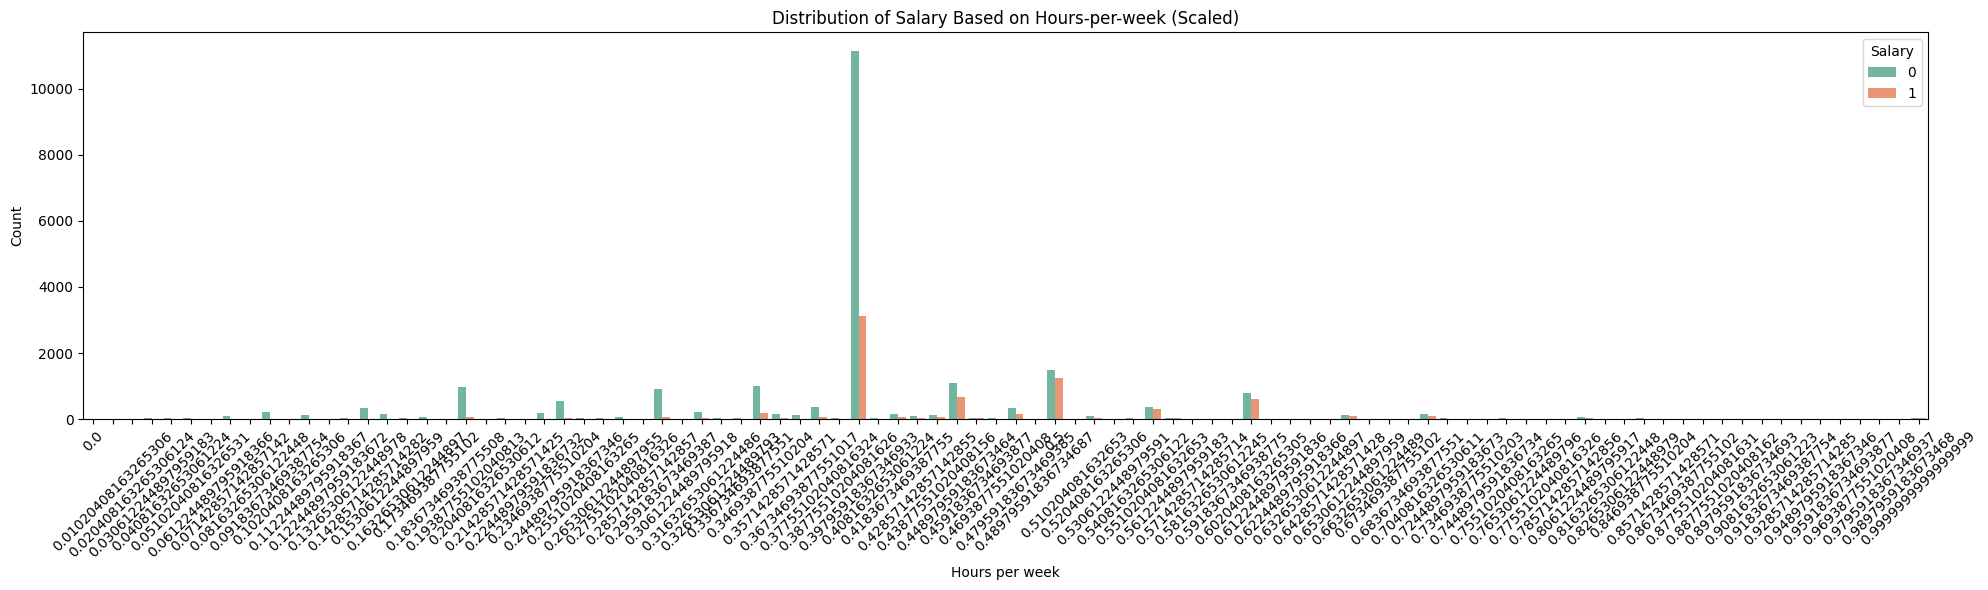

In [336]:
plt.figure(figsize=(20, 6))
sns.countplot(x='hours-per-week_scaled', hue='salary', data=df, palette='Set2')
plt.title('Distribution of Salary Based on Hours-per-week (Scaled)')
plt.xlabel('Hours per week')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Salary')
plt.tight_layout()
plt.show()
plt.close()

### Capital gain and Capital loss

Creiamo la nuova variabile categorica a partire dalle variabili **capital-gain** e **capital-loss**. Le categorie saranno: 'loss' per chi ha investito e ha subito delle perdite, 'none' per chi non ha investito e 'gain' per chi ha investito e ha ottenuto dei guadagni.

In [337]:
for i, row in df.iterrows():
  gain = row['capital-gain']
  loss = row['capital-loss']
  if gain > 0:
    df.loc[i, 'capital_cat'] = 'gain'
  elif loss > 0:
    df.loc[i, 'capital_cat'] = 'loss'
  else:
    df.loc[i, 'capital_cat'] = 'none'

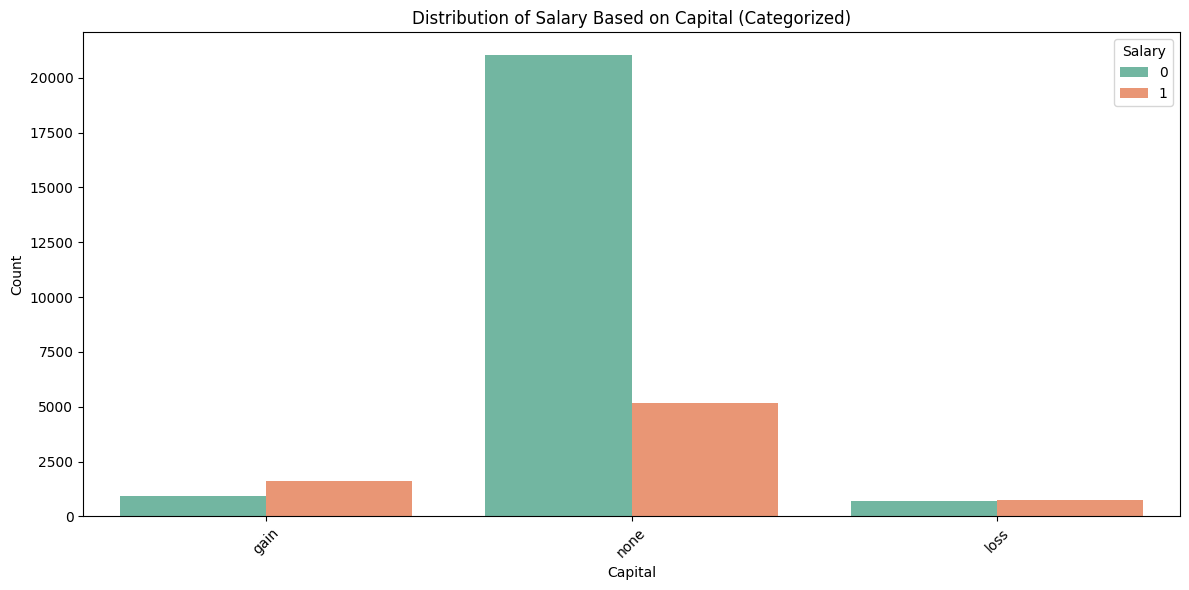

In [338]:
plt.figure(figsize=(12, 6))
sns.countplot(x='capital_cat', hue='salary', data=df, palette='Set2')
plt.title('Distribution of Salary Based on Capital (Categorized)')
plt.xlabel('Capital')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Salary')
plt.tight_layout()
plt.show()
plt.close()

In [339]:
salary_mean = df.groupby(['capital_cat'])['salary'].mean()
salary_mean

capital_cat
gain    0.628448
loss    0.516468
none    0.197580
Name: salary, dtype: float64

Le due categorie che indicano le persone che hanno investito sono abbastanza simili e nettamente diverse dalla media delle persone che non hanno mai investito. Possiamo accorpare queste due categorie in una, trasformando la variabile in una variabile binaria che distingue le persone che hanno investito da quelle che non hanno investito.

In [340]:
df = df.replace(['gain', 'loss'], 'yes')
df = df.replace(['none'], 'no')

In [341]:
salary_mean = df.groupby(['capital_cat'])['salary'].mean()
salary_mean

capital_cat
no     0.197580
yes    0.588146
Name: salary, dtype: float64

Ora effettuiamo la codifica binaria.

In [342]:
mapping = {'no': 0, 'yes': 1}
df['capital_cat'] = df['capital_cat'].map(mapping)

Ora passiamo alla normalizzazione delle variabili ***capital-gain*** e ***capital-loss***. Ribadiamo che entrambe le varibaili hanno presentato un'asimmetria nella distribuzione.

Spesso, viene utilizzata la log trasformation, per diminuire la skewness dei dati. La log trasformation è una tecnica di trasformazione dei dati che rimpiazza ogni variabile $x$ con il logaritmo di $x$, $\log(x)$.

Di conseguenza, si è deciso di applicare sia la log trasformation che la normalizzazione minmax. Per entrambe le normalizzazione verrano create delle variabili corrispondenti.

In [343]:
df['capital-gain_log'] = np.log(df['capital-gain'] + 1)
df['capital-loss_log'] = np.log(df['capital-loss'] + 1)

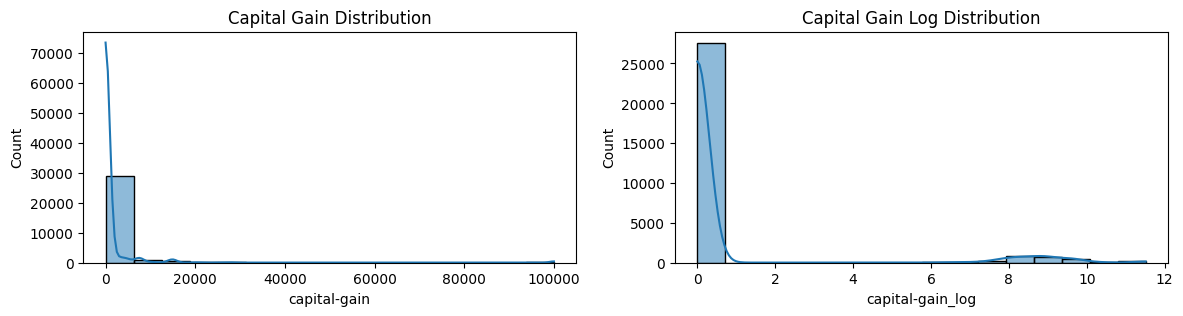

In [344]:
fig, ax = plt.subplots(1, 2, figsize=(14, 3))
sns.histplot(df['capital-gain'], ax=ax[0], kde=True)
ax[0].set_title('Capital Gain Distribution')
sns.histplot(df['capital-gain_log'], ax=ax[1], kde=True)
ax[1].set_title('Capital Gain Log Distribution')
plt.show()
plt.close()

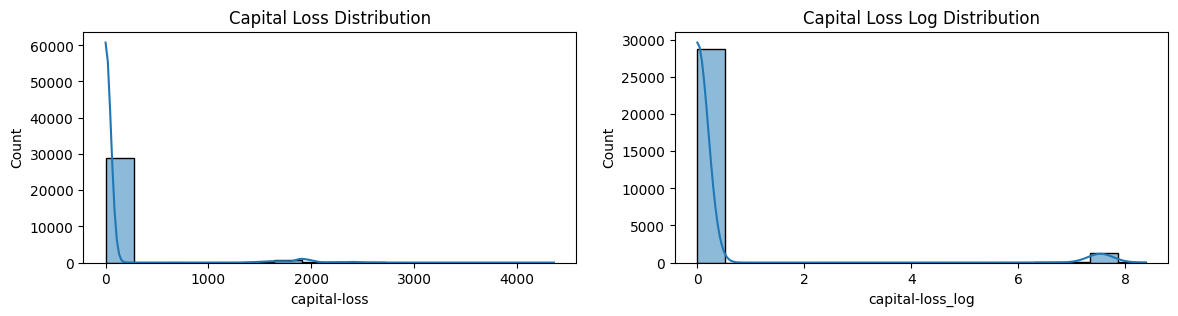

In [345]:
fig, ax = plt.subplots(1, 2, figsize=(14, 3))
sns.histplot(df['capital-loss'], ax=ax[0], kde=True)
ax[0].set_title('Capital Loss Distribution')
sns.histplot(df['capital-loss_log'], ax=ax[1], kde=True)
ax[1].set_title('Capital Loss Log Distribution')
plt.show()
plt.close()

In [346]:
minmax_scaler = MinMaxScaler()
df['capital-gain_scaled'] = minmax_scaler.fit_transform(df[['capital-gain']])
df['capital-loss_scaled'] = minmax_scaler.fit_transform(df[['capital-loss']])

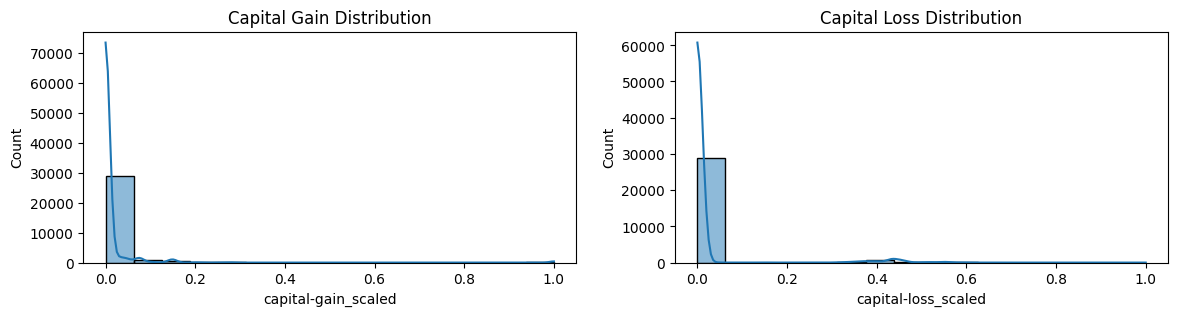

In [347]:
fig, ax = plt.subplots(1, 2, figsize=(14, 3))
sns.histplot(df['capital-gain_scaled'], ax=ax[0], kde=True)
ax[0].set_title('Capital Gain Distribution')
ax[0].xlabel = ('Capital Gain')
sns.histplot(df['capital-loss_scaled'], ax=ax[1], kde=True)
ax[1].set_title('Capital Loss Distribution')
ax[1].xlabel = ('Capital Loss')
plt.show()
plt.close()

### Education and education-num

Gestiamo le variabili ***education*** ed ***education-num***. Nella fase di analisi, abbiamo stabilito di effettuare due operazioni: la prima consiste nel raggruppamento di alcune categorie, la seconda prevede di eliminare una delle due variabili. Siccome gli algoritmi di machine learning necessitano di dati numeri, ha senso mantenere la variabile numerica. Nonostante ciò, precediamo ad effettuare le varie modifiche sulla variabile categorica (di tipo object) per poi codificarla in variabile categorica numerica. Questo perché se facessimo le operazioni su ***education-num***, sarebbe necessario poi riordinare i valori dopo il raggruppamento delle categorie.

Procediamo con il raggruppamento delle categorie. Raggruppiamo tutti i livelli di istruzione inferiori al diploma di maturità, quindi 'Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th' che diventano 'Before-HS'. 'Assoc-voc' e 'Assoc-acdm' diventano 'Assoc'.

In [348]:
df = df.replace([' Assoc-voc', ' Assoc-acdm'], ' Assoc')
df = df.replace([' Preschool', ' 1st-4th', ' 5th-6th', ' 7th-8th', ' 9th', ' 10th', ' 11th', ' 12th'], ' Before-HS')

Vediamo come sono variate le medie.

In [349]:
salary_mean = df.groupby(['education'])['salary'].mean()
salary_mean

education
 Assoc           0.259179
 Bachelors       0.421491
 Before-HS       0.060144
 Doctorate       0.746667
 HS-grad         0.164329
 Masters         0.564229
 Prof-school     0.749077
 Some-college    0.200060
Name: salary, dtype: float64

Le categorie 'Doctorate' e 'Prof-school', hanno la stessa media. Rappresentano entrambe lo stesso livello di sitruzione, solo che 'Doctorate' è a livello accademico, 'Prof-school' è a livello professionale. Possiamo raggruppare anche queste due categorie.

In [350]:
df = df.replace([' Doctorate', ' Prof-school'], ' Doc-Prof')

Effettuaiamo una codifica ordinata della variabile usando il mapping.

In [351]:
mapping = {' Before-HS': 0, ' HS-grad': 1, ' Some-college': 2, ' Assoc':3, ' Bachelors':4, ' Masters':5, ' Doc-Prof':6}
df['education'] = df['education'].map(mapping)

Vediamo graficamente le modifiche effettuate, conforntando le due distribuzioni.

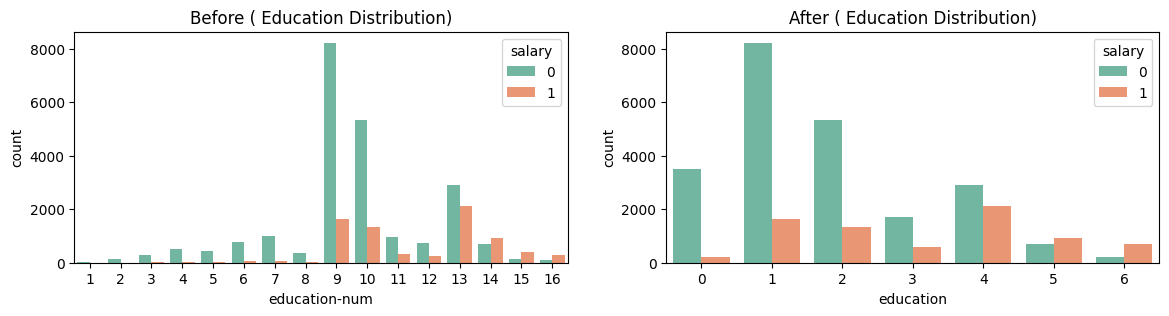

In [352]:
fig, ax = plt.subplots(1, 2, figsize=(14, 3))
sns.countplot(x='education-num', hue='salary', data=df, palette='Set2', ax=ax[0])
ax[0].set_title('Before ( Education Distribution)')
sns.countplot(x='education', hue='salary', data=df, palette='Set2', ax=ax[1])
ax[1].set_title('After ( Education Distribution)')
plt.show()
plt.close()

Abbiamo ridotto il numero di categori da 16 a 6.

### Marital status & relationship

Abbiamo deciso di gestire la variabile ***marital-status*** raggruppando alcune categorie. Effettuiamo i raggruppamenti utilizzando una nuova variabile, così da poter analizzare successivamente l'esito di queste modifiche.

Come detto nella fase di analisi, considerando anche le relazioni studiate tra ***marital-status*** e ***relationship***, raggruppiamo 'Married-civ-spouse' e 'Maried-AF-spouse' in un'unica categoria che chiamiamo 'Married'. Poi aggreghiamo la categoria 'Married-spouse-absent' con la categoria 'Separated'.

In [353]:
df['new_marital-status'] = df['marital-status']
df['new_marital-status'] = df['new_marital-status'].replace([' Married-civ-spouse', ' Married-AF-spouse'] , ' Married')
df['new_marital-status'] = df['new_marital-status'].replace(' Married-spouse-absent', ' Separated')

Vediamo graficamente come è variata la distribuzione dei dati.

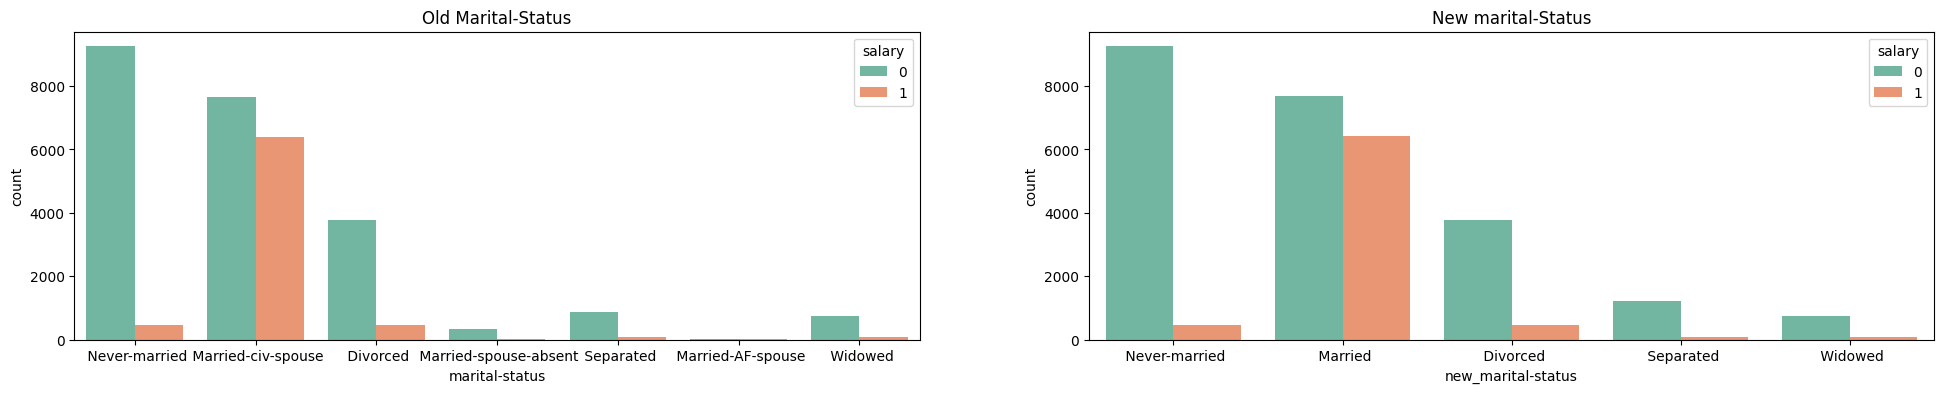

In [354]:
fig, ax = plt.subplots(1, 2, figsize=(24, 4))
sns.countplot(x='marital-status', hue='salary', data=df, palette='Set2', ax=ax[0])
ax[0].set_title('Old Marital-Status')
sns.countplot(x='new_marital-status', hue='salary', data=df, palette='Set2', ax=ax[1])
ax[1].set_title('New marital-Status')
plt.show()
plt.close()

### Workclass

Nella fase di analisi è stata trovata una categoria della variabile ***workclass***, poco significanete per la predizione. La categoria in questione è 'Without-pay': procediamo con la sua rimozione.

In [355]:
df = df[df['workclass'] != ' Without-pay']
df['workclass'].value_counts()

 Private             22286
 Self-emp-not-inc     2499
 Local-gov            2067
 State-gov            1279
 Self-emp-inc         1074
 Federal-gov           943
Name: workclass, dtype: int64

## Feature Selection

In questa fase, scegliamo le variabile da utilizzare per la predizione del modello. Usiamo la matrice di correlazione per poter confrontare la potenza predittiva di ogni singola variabile, confrontando soprattuto le variabili modificate.

Innanzitutto, separiamo le variabili in formato numerico da quelle in formato stringa, così da poter costruire la matrice di correlazione con le variabili numeriche.

In [356]:
num_features = [i for i in df if df[i].dtype != 'object' and df[i].dtype != 'category']
print(num_features)


['age', 'fnlwgt', 'education', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'salary', 'age_scaled', 'age_cat', 'hours-per-week_cat', 'hours-per-week_scaled', 'capital_cat', 'capital-gain_log', 'capital-loss_log', 'capital-gain_scaled', 'capital-loss_scaled']


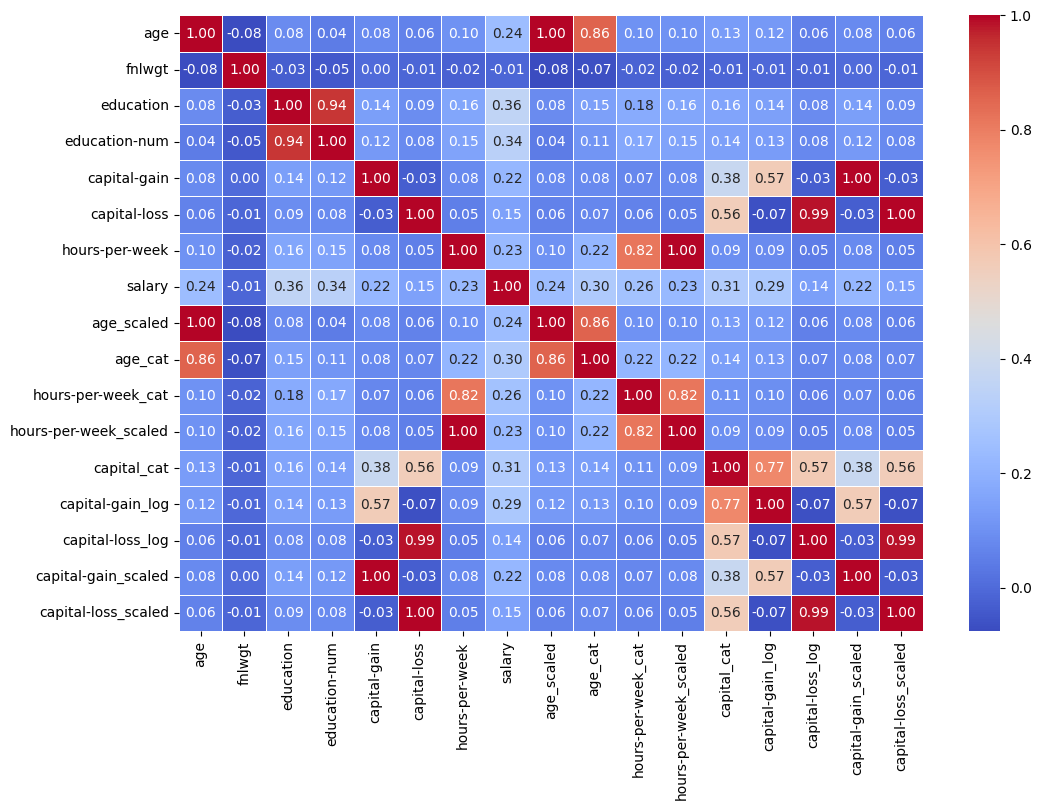

In [357]:
correlation_matrix = df[num_features].corr(numeric_only = True)
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.show()

La matrice di correlazione ci aiuta a capire quanto sono correlati i dati tra di loro. Osserviamo le variabili modificate.

Per quanto riguarda la variabile ***age***, ha un coefficiente di correlazione con salary pari a 0.24, uguale a quello della variabile ***age_scaled***. La variabile ***age_cat***, invece, ha un coefficiente di correlazione con salary pari a 0.30.

Per quanto riguarda ***education***, la variabile su cui sono state raggruppate le categorie, ha un coefficiente di correlazione pari a 0.36: è incrementato rispetto al suo valore iniziale, pari a 0.34.

Le variabili ***hours-per-week*** e ***hours-per-week_scaled*** hanno un coefficiente di correlazione pari a 0.23, mentre la loro versione categorizzata, hours-per-week_cat ha un coefficiente di correlazione uguale a 0.26.

La variabile ***capital-gain_log*** ha un coefficiente di correlazione uguale a 0.29, il che è maggiore della versione normale e di quella normalizzata con MinMaxScaler. invece, ***capital-gain_log*** ha un coefficente di correlazione inferiore, che è pari a 0.14, rispetto allo 0.15 della versione normale e di quella normalizzata.
D'altra parte, la variabile ***capital_cat*** ha un coefficiente di correlazione con la variabile ***salary*** pari a 0.31.

Da notare, invece, il coefficiente di correlazione di ***fnlwgt*** (variabile che non considereremo nella predizione) il quale è l'unico coefficiente negativo.

La matrice di correlazione ha mostrato che le variabili categorizzate risultano avere più potenza predittiva.

Eliminiamo le variabili che abbiamo deciso di non utilizzare per la predizione.

In [358]:
df = df.drop(columns=['native-country', 'relationship', 'fnlwgt', 'education-num', 'marital-status', 'age'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30148 entries, 0 to 32560
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   workclass              30148 non-null  object 
 1   education              30148 non-null  int64  
 2   occupation             30148 non-null  object 
 3   race                   30148 non-null  object 
 4   sex                    30148 non-null  object 
 5   capital-gain           30148 non-null  int64  
 6   capital-loss           30148 non-null  int64  
 7   hours-per-week         30148 non-null  int64  
 8   salary                 30148 non-null  int64  
 9   age_scaled             30148 non-null  float64
 10  age_cat                30148 non-null  float64
 11  hours-per-week_cat     30148 non-null  float64
 12  hours-per-week_scaled  30148 non-null  float64
 13  capital_cat            30148 non-null  int64  
 14  capital-gain_log       30148 non-null  float64
 15  ca

Ora abbiamo bisogno di codificare le variabili categoriche, in modo tale che possano essere date in input all'algoritmo di machine learning.
Si è scelto di utilizzare il metodo `get_dummies` di *`pandas`*, che effettua la one hot encoding direttamente sul datatset, modificando quest'ultimo inserendo una colonna per ogni categoria di una variabile. Per una tederminata riga, quella colonna può assumere o valore 0, se non appartiene a quella categoria, o valore 1, se appartiene a quella categoria.

Effettuata la codifica, separiamo le variabili indipendenti e quelle dipendenti.

In [359]:
cat_features = [i for i in df if df[i].dtype == 'object' or df[i].dtype == 'category']
print(cat_features)
df_encoded = pd.get_dummies(df, columns=cat_features, dtype=int)
y = df['salary']

X = df_encoded.drop(columns=['salary'])

['workclass', 'occupation', 'race', 'sex', 'new_marital-status']


# Train and Test

In questa fase andiamo ad addestare e valutare il modello in base al tipo di variabili che gli vengono fornite.

Il modello che è stato scelto per il problema è il Decision Tree Classifier, il quale si adatta bene sia ai dati categorici che quelli numerici.

Di seguito è mostrata la funzione `fit_and_test`, la qualwe è stata implementata per svolgere sia l'addetsramento del modello, che la sua valutazione. La funzione stamperà la matrice di confuzione risultate e le metriche di valutazione, nello specifico usare l'accurancy, la recall e la precision. Sarà data più importanza alla precision e alla recall.



In [546]:
def fit_and_test(classifier: pd.DataFrame, X_train, y_train, X_test, y_test):
  print(classifier.__class__.__name__)
  classifier.fit(X_train, y_train)
  predictions = classifier.predict(X_test)
  # show confusion matrix
  cm = confusion_matrix(y_test, predictions, labels=[0, 1])
  display = ConfusionMatrixDisplay(confusion_matrix=cm)
  display.plot()
  plt.show()
  # show metrics
  accurancy = accuracy_score(y_test, predictions)
  # print("Accurancy:" + str(accurancy))
  recall = recall_score(y_test, predictions)
  print("Recall:" + str(recall))
  precision = precision_score(y_test, predictions)
  print("Precision:" + str(precision))

In [547]:
col_to_test = ['age_scaled', 'age_cat', 'hours-per-week_cat', 'hours-per-week_scaled', 'capital-loss_log', 'capital-gain_log', 'capital-gain_scaled', 'capital-loss_scaled', 'capital_cat']

Questa è la lista delle variabili da testare. Ad ogni test, verranno rimosse queste variabili, tranne la variabile che si sta testando.

In [557]:
x = random.randint(0, 256)

### Age

Prestazioni con ***age_cat***.

DecisionTreeClassifier


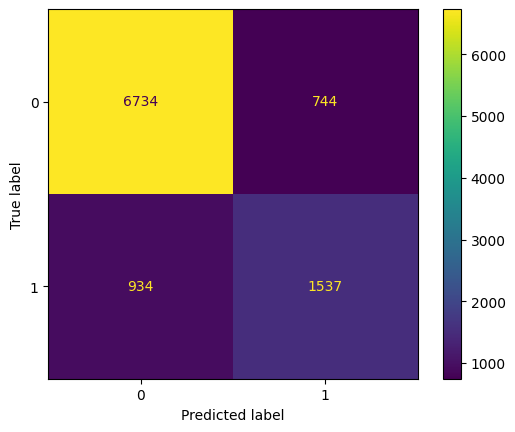

Recall:0.6220153783893161
Precision:0.6738272687417799


In [558]:
col = copy.deepcopy(col_to_test)
col.remove('age_cat')
X1 = X.drop(columns=col)
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.33, random_state=x)
fit_and_test(DecisionTreeClassifier(), X_train, y_train, X_test, y_test)

Prestazioni con ***age_scaled***.

DecisionTreeClassifier


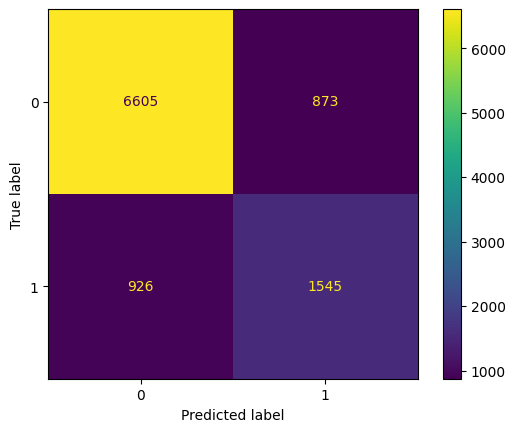

Recall:0.6252529340348038
Precision:0.6389578163771712


In [559]:
col = copy.deepcopy(col_to_test)
col.remove('age_scaled')
X1 = X.drop(columns=col)
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.33, random_state=x)
fit_and_test(DecisionTreeClassifier(), X_train, y_train, X_test, y_test)

L'algoritmo sembra preferire la variabile ***age*** categorizzata piuttosto che scalata.

### Hours per week

Prestazioni con ***hours-per-week_cat***.

DecisionTreeClassifier


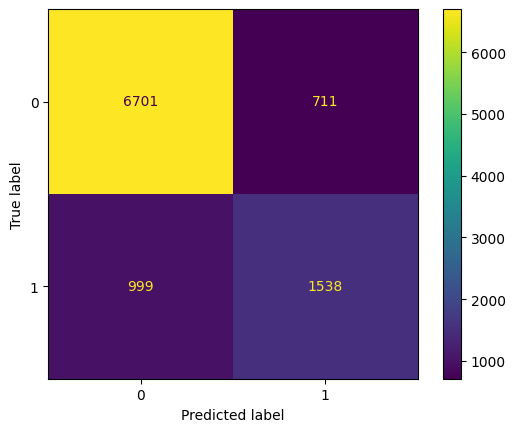

Recall:0.6062278281434765
Precision:0.683859493108048


In [551]:
col = copy.deepcopy(col_to_test)
for i in ['age_cat', 'hours-per-week_cat']:
  col.remove(i)
X1 = X.drop(columns=col)
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.33, random_state=x)
fit_and_test(DecisionTreeClassifier(), X_train, y_train, X_test, y_test)

Prestazioni con ***hours-per-week_scaled***.

DecisionTreeClassifier


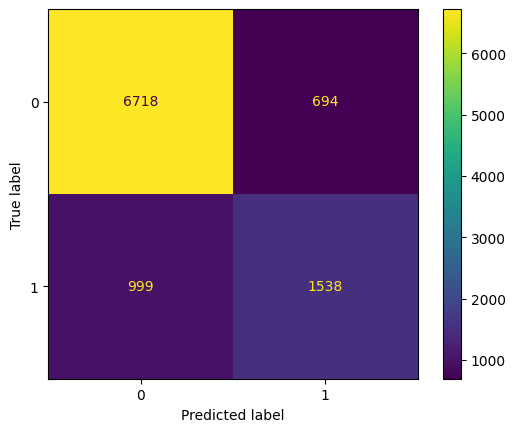

Recall:0.6062278281434765
Precision:0.6890681003584229


In [552]:
col = copy.deepcopy(col_to_test)
for i in ['age_cat', 'hours-per-week_scaled']:
  col.remove(i)
X1 = X.drop(columns=col)
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.33, random_state=x)
fit_and_test(DecisionTreeClassifier(), X_train, y_train, X_test, y_test)

Anche qui l'algoritmo sembra preferire la variabile categorizzata.

### Capital gain and Capital loss

Prestazioni con **capital_cat**.

DecisionTreeClassifier


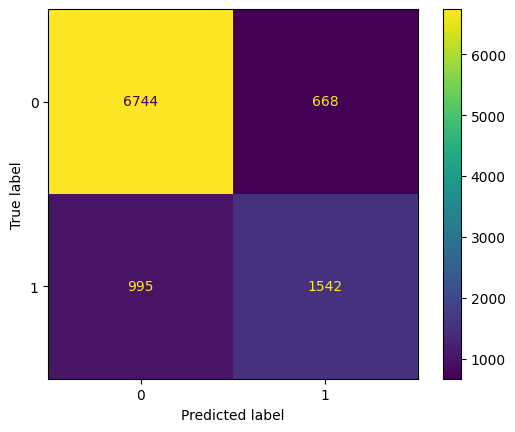

Recall:0.6078044934962554
Precision:0.6977375565610859


In [553]:
col = copy.deepcopy(col_to_test)
for i in ['age_cat', 'hours-per-week_cat', 'capital_cat']:
  col.remove(i)
X1 = X.drop(columns=col)
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.33, random_state=x)
fit_and_test(DecisionTreeClassifier(), X_train, y_train, X_test, y_test)

Log

DecisionTreeClassifier


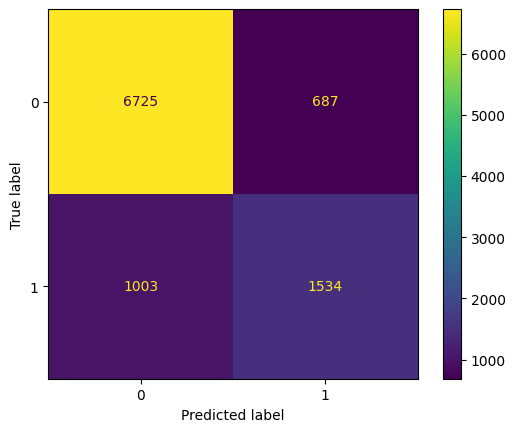

Recall:0.6046511627906976
Precision:0.6906798739306619


In [554]:
col = copy.deepcopy(col_to_test)
for i in ['age_cat', 'hours-per-week_cat', 'capital-gain_log', 'capital-loss_log']:
  col.remove(i)
X1 = X.drop(columns=col)
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.33, random_state=x)
fit_and_test(DecisionTreeClassifier(), X_train, y_train, X_test, y_test)

Scaled

DecisionTreeClassifier


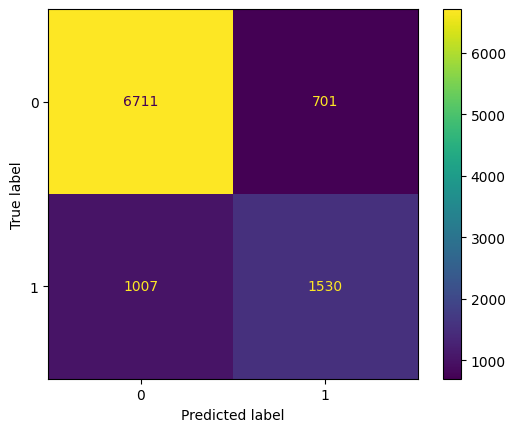

Recall:0.6030744974379189
Precision:0.6857911250560287


In [555]:
col = copy.deepcopy(col_to_test)
for i in ['age_cat', 'hours-per-week_cat', 'capital-gain_scaled', 'capital-loss_scaled']:
  col.remove(i)
X1 = X.drop(columns=col)
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.33, random_state=x)
fit_and_test(DecisionTreeClassifier(), X_train, y_train, X_test, y_test)

DecisionTreeClassifier


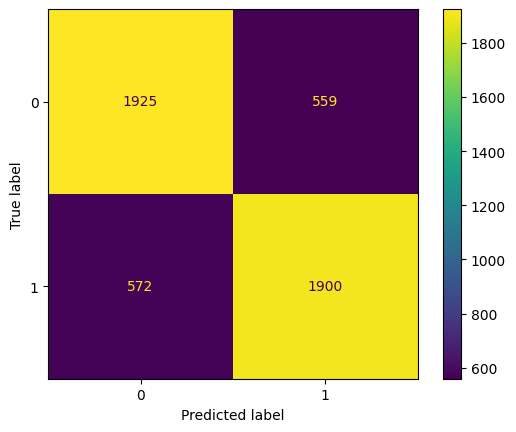

Recall:0.7686084142394822
Precision:0.7726718178121188


In [556]:
rus = RandomUnderSampler(sampling_strategy=1)
X2_s, y_s = rus.fit_resample(X2, y)
X_train, X_test, y_train, y_test = train_test_split(X2_s, y_s, test_size=0.33, random_state=x)
fit_and_test(DecisionTreeClassifier(), X_train, y_train, X_test, y_test)

# Cross-validation

Hours per week

In [366]:
X1 = X.drop(columns=['hours-per-week_cat', 'hours-per-week_scaled'])
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.1, random_state=x)
fit_and_test(CategoricalNB(), X_train, y_train, X_test, y_test)

CategoricalNB
Recall:0.5756756756756757
Precision:0.7395833333333334


In [469]:
rfk = RepeatedKFold(n_splits=2, n_repeats=1, random_state=x)
tests =list(["accuracy", "precision", "recall"])
cv_score = cross_validate(CategoricalNB(), X_train, y_train, cv=rfk, n_jobs=3, verbose=1, scoring=tests)
fit_time_mean = statistics.mean(cv_score['fit_time'])
score_time_mean = statistics.mean(cv_score['score_time'])
accuracy_mean = statistics.mean(cv_score['test_accuracy'])
precision_mean = statistics.mean(cv_score['test_precision'])
recall_mean = statistics.mean(cv_score['test_recall'])
print(fit_time_mean)
print(score_time_mean)
print(accuracy_mean)
print(precision_mean)
print(recall_mean)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


0.1136254072189331
0.04990983009338379
nan
nan
nan


[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    0.2s finished


Hours per week cat

In [201]:
X2 = X.drop(columns=['hours-per-week', 'hours-per-week_scaled'])
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.33, random_state=x)

In [202]:
rfk = RepeatedKFold(n_splits=10, n_repeats=4, random_state=random.randint(0,256))
tests =list(["accuracy", "precision", "recall"])
cv_score = cross_validate(DecisionTreeClassifier(), X_train, y_train, cv=rfk, n_jobs=3, verbose=5, scoring=tests)
fit_time_mean = statistics.mean(cv_score['fit_time'])
score_time_mean = statistics.mean(cv_score['score_time'])
accuracy_mean = statistics.mean(cv_score['test_accuracy'])
precision_mean = statistics.mean(cv_score['test_precision'])
recall_mean = statistics.mean(cv_score['test_recall'])
print(fit_time_mean)
print(score_time_mean)
print(accuracy_mean)
print(precision_mean)
print(recall_mean)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    1.3s


0.24706894755363465
0.018292897939682008
0.820635000907223
0.6449988266045575
0.6094314556103769


[Parallel(n_jobs=3)]: Done  40 out of  40 | elapsed:    3.8s finished


Hours per week scaled

In [203]:
X2 = X.drop(columns=['hours-per-week', 'hours-per-week_cat'])
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.33, random_state=x)

In [204]:
rfk = RepeatedKFold(n_splits=10, n_repeats=4, random_state=random.randint(0,256))
tests =list(["accuracy", "precision", "recall"])
cv_score = cross_validate(DecisionTreeClassifier(), X_train, y_train, cv=rfk, n_jobs=3, verbose=5, scoring=tests)
fit_time_mean = statistics.mean(cv_score['fit_time'])
score_time_mean = statistics.mean(cv_score['score_time'])
accuracy_mean = statistics.mean(cv_score['test_accuracy'])
precision_mean = statistics.mean(cv_score['test_precision'])
recall_mean = statistics.mean(cv_score['test_recall'])
print(fit_time_mean)
print(score_time_mean)
print(accuracy_mean)
print(precision_mean)
print(recall_mean)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    1.5s


0.33599231839179994
0.024906522035598753
0.8156589748870875
0.6305821943248122
0.6146276354078022


[Parallel(n_jobs=3)]: Done  40 out of  40 | elapsed:    5.1s finished
